# **Optiver Realized Volatility Prediction**

## **Installations, Libraries, Options, and Parameters**

### Installations

Install nvidia

In [ ]:
!nvidia-smi

Sun May  7 16:49:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 385 (delta 86), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (385/385), 105.74 KiB | 2.25 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.9 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.

In [ ]:
import cudf, cuml
cudf.__version__

'23.04.01'

### Upload Kaggle Dataset

In [ ]:
# Install the Kaggle library
!pip install -q kaggle

In [ ]:
# Make a directory named “.kaggle”
!mkdir ~/.kaggle

In [ ]:
# Copy the “kaggle.json” into this new directory
!cp kaggle.json ~/.kaggle/

In [ ]:
# Allocate the required permission for this file.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download competition dataset
!kaggle competitions download optiver-realized-volatility-prediction

 99% 1.58G/1.59G [00:09<00:00, 154MB/s]
100% 1.59G/1.59G [00:09<00:00, 171MB/s]


In [ ]:
# Create a directory for unzipped data
!mkdir train

In [ ]:
# Unzip data in the new directory
!unzip optiver-realized-volatility-prediction.zip -d train

Archive:  optiver-realized-volatility-prediction.zip
  inflating: train/book_test.parquet/stock_id=0/7832c05caae3489cbcbbb9b02cf61711.parquet  
  inflating: train/book_train.parquet/stock_id=0/c439ef22282f412ba39e9137a3fdabac.parquet  
  inflating: train/book_train.parquet/stock_id=1/31a1c5cd6d8546b383d10373db762236.parquet  
  inflating: train/book_train.parquet/stock_id=10/d671bb2b87f447d4ba3fa4b18b3656f9.parquet  
  inflating: train/book_train.parquet/stock_id=100/9495f2c64cee42078601dee7408e3c36.parquet  
  inflating: train/book_train.parquet/stock_id=101/dbbf6dc725ee4bcb8656c427165c888d.parquet  
  inflating: train/book_train.parquet/stock_id=102/9d16ca233fea42c7a8ec91d621ca113a.parquet  
  inflating: train/book_train.parquet/stock_id=103/cc7984f01a8747299339cb441632d6c0.parquet  
  inflating: train/book_train.parquet/stock_id=104/6875618fb8144a80a033ae8de7809493.parquet  
  inflating: train/book_train.parquet/stock_id=105/a37b8bf4be2e4fa5b3ea63b7c4240d3d.parquet  
  inflating: tr

### Libraries

In [ ]:
# Import libraries

import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from collections import defaultdict
from IPython.display import display
import gc
from cudf import DataFrame
import time
import warnings
%matplotlib inline

### Set Options

In [ ]:
# Set pandas options

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

print("Threshold:", gc.get_threshold())
print("Count:", gc.get_count())

Threshold: (700, 10, 10)
Count: (101, 1, 13)


### Define Parameters

In [ ]:
# Data directory
DIR = "/content/train/"

# Number of execution cycles
ROUNDS = 30

### Data

In [ ]:
# Get order and trade books
order_files = glob.glob(DIR + "book_train.parquet" + "/*")
trade_files = glob.glob(DIR + "trade_train.parquet" + "/*")
print(order_files[:5])
print("\n")
print(trade_files[:5])
print("\n")

# Get stock_ids as a list
stock_ids = sorted([int(file.split('=')[1]) for file in order_files])
print(f"{len(stock_ids)} stocks: \n {stock_ids} \n")

['/content/train/book_train.parquet/stock_id=74', '/content/train/book_train.parquet/stock_id=100', '/content/train/book_train.parquet/stock_id=30', '/content/train/book_train.parquet/stock_id=56', '/content/train/book_train.parquet/stock_id=88']


['/content/train/trade_train.parquet/stock_id=74', '/content/train/trade_train.parquet/stock_id=100', '/content/train/trade_train.parquet/stock_id=30', '/content/train/trade_train.parquet/stock_id=56', '/content/train/trade_train.parquet/stock_id=88']


112 stocks: 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 55, 56, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126] 



## **Data Frame Operations**

### 1. Loading and Filling Data Frames

#### a. Loading Data Frames

In [ ]:
def load_dataframe(files, dframe=0):

    print("LOADING DATA FRAMES", "\n")
    
    # Load the pandas dataframe
    if dframe == 0: 
      print("Loading pandas dataframe..", "\n")
      start = time.time()
      df_pandas = pd.read_parquet(files[0])
      end = time.time()
      elapsed_time = round(end-start, 3)
      print(f"For pandas dataframe: \n start time: {start} \n end time: {end} \n elapsed time: {elapsed_time} \n")
      return df_pandas, elapsed_time

    # Load the cuDF dataframe
    else:
      print("Loading cuDF dataframe..", "\n")
      start = time.time()
      df_cudf = cudf.read_parquet(files[0])
      end = time.time()
      elapsed_time = round(end-start, 3)
      print(f"For cuDF dataframe: \n start time: {start} \n end time: {end} \n elapsed time: {elapsed_time} \n ")

      return df_cudf, elapsed_time

In [ ]:
 # Load pandas order dataframe and calculate time
df_pd_order, _ = load_dataframe(order_files, dframe=0)
display(df_pd_order.head())

LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683478477.7467628 
 end time: 1683478477.9807515 
 elapsed time: 0.234 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  2    1.003479    1.004387    1.003177    1.004689   
2        5                  4    1.003479    1.004387    1.003177    1.004689   
3        5                 11    1.003479    1.004387    1.003177    1.004689   
4        5                 13    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  
0          9        403        100        200  
1         92        403        100        200  
2         92        303        100        200  
3         97        303        100        200  
4         97        303        100        200

In [ ]:
# Load cuDF book dataframe and calculate time
df_cudf_order, _ = load_dataframe(order_files, dframe=1)
display(df_cudf_order.head())

LOADING DATA FRAMES 

Loading cuDF dataframe.. 

For cuDF dataframe: 
 start time: 1683478478.0102234 
 end time: 1683478482.0671437 
 elapsed time: 4.057 
 


time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  2    1.003479    1.004387    1.003177    1.004689   
2        5                  4    1.003479    1.004387    1.003177    1.004689   
3        5                 11    1.003479    1.004387    1.003177    1.004689   
4        5                 13    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  
0          9        403        100        200  
1         92        403        100        200  
2         92        303        100        200  
3         97        303        100        200  
4         97        303        100        200

In [ ]:
# Order dataframe info
display(df_pd_order.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393517 entries, 0 to 1393516
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   time_id            1393517 non-null  int16  
 1   seconds_in_bucket  1393517 non-null  int16  
 2   bid_price1         1393517 non-null  float32
 3   ask_price1         1393517 non-null  float32
 4   bid_price2         1393517 non-null  float32
 5   ask_price2         1393517 non-null  float32
 6   bid_size1          1393517 non-null  int32  
 7   ask_size1          1393517 non-null  int32  
 8   bid_size2          1393517 non-null  int32  
 9   ask_size2          1393517 non-null  int32  
dtypes: float32(4), int16(2), int32(4)
memory usage: 47.8 MB


None

In [ ]:
# Load pandas trade dataframe and calculate time 
df_pd_trade, _ = load_dataframe(trade_files, dframe=0)
display(df_pd_trade.head())

LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683478482.1742492 
 end time: 1683478482.1903565 
 elapsed time: 0.016 



time_id  seconds_in_bucket     price  size  order_count
0        5                 26  1.004387   304            4
1        5                 69  1.003782   250            8
2        5                 90  1.004372   210            3
3        5                101  1.004992     1            1
4        5                114  1.004992  2307           28

In [ ]:
# Load cuDF trade dataframe and calculate time
df_cudf_trade, _ = load_dataframe(trade_files, dframe=1)
display(df_cudf_trade.head())

LOADING DATA FRAMES 

Loading cuDF dataframe.. 

For cuDF dataframe: 
 start time: 1683478482.20327 
 end time: 1683478482.2354243 
 elapsed time: 0.032 
 


time_id  seconds_in_bucket     price  size  order_count
0        5                 26  1.004387   304            4
1        5                 69  1.003782   250            8
2        5                 90  1.004372   210            3
3        5                101  1.004992     1            1
4        5                114  1.004992  2307           28

In [ ]:
# Trade dataframe info
display(df_pd_trade.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276080 entries, 0 to 276079
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            276080 non-null  int16  
 1   seconds_in_bucket  276080 non-null  int16  
 2   price              276080 non-null  float32
 3   size               276080 non-null  int32  
 4   order_count        276080 non-null  int16  
dtypes: float32(1), int16(3), int32(1)
memory usage: 3.7 MB


None

#### b. Filling Data Frames

In [ ]:
# Forward fill data
def ffill(df, df_name="order"):
    
    # Forward fill
    df_pandas = df.set_index(['time_id', 'seconds_in_bucket'])

    if df_name == "order":
      df_pandas = df_pandas.reindex(pd.MultiIndex.from_product([df_pandas.index.levels[0], np.arange(0,600)], names = ['time_id', 'seconds_in_bucket']), method='ffill')
      df_pandas = df_pandas.reset_index()
      
    else:
      df_pandas = df_pandas.reindex(pd.MultiIndex.from_product([df_pandas.index.levels[0], np.arange(0,600)], names = ['time_id', 'seconds_in_bucket']))
      # Fill nan values with 0
      df_pandas = df_pandas.fillna(0)
      df_pandas = df_pandas.reset_index()    

    # Convert to a cudf dataframe
    df_cudf = cudf.DataFrame.from_pandas(df_pandas)

    return df_pandas, df_cudf

In [ ]:
# Forward fill order dataframes
expanded_df_pd_order, expanded_df_cudf_order = ffill(df_pd_order, df_name="order")
display(expanded_df_cudf_order.head())

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  
0          9        403        100        200  
1          9        403        100        200  
2         92        403        100        200  
3         92        403        100        200  
4         92        303        100        200

In [ ]:
# Forward fill trade dataframes
expanded_df_pd_trade, expanded_df_cudf_trade = ffill(df_pd_trade, df_name="trade")
display(expanded_df_cudf_trade.head())

time_id  seconds_in_bucket  price  size  order_count
0        5                  0    0.0   0.0          0.0
1        5                  1    0.0   0.0          0.0
2        5                  2    0.0   0.0          0.0
3        5                  3    0.0   0.0          0.0
4        5                  4    0.0   0.0          0.0

### 2. Merging Data Frames

In [ ]:
def merge_dataframes(df1, df2, dframe=0):

    print("MERGING DATA FRAMES", "\n")
    
    if dframe == 0:
      df_type = "Pandas"
    else:
      df_type = "cuDF"

    # Merge dataframes
    print(f"Merging {df_type} dataframes..", "\n")
    start = time.time()
    df = df1.merge(df2, how="left", on=["time_id", "seconds_in_bucket"], sort=True)
    end = time.time()
    elapsed_time = round(end-start, 3)
    print(f"For {df_type} dataframes: \n start time: {start} \n end time: {end} \n elapsed time: {elapsed_time} \n")

    return df, elapsed_time

In [ ]:
# Merge pandas order and trade dataframes
df_pd, pd_merge_time = merge_dataframes(expanded_df_pd_order, expanded_df_pd_trade, dframe=0)
display(df_pd.head())

MERGING DATA FRAMES 

Merging Pandas dataframes.. 

For Pandas dataframes: 
 start time: 1683478487.6793175 
 end time: 1683478488.9939837 
 elapsed time: 1.315 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  
0          9        403        100        200    0.0   0.0          0.0  
1          9        403        100        200    0.0   0.0          0.0  
2         92        403        100        200    0.0   0.0          0.0  
3         92        403        100        200    0.0   0.0          0.0  
4         92        303        100        200    0.0   0.0          0.0

In [ ]:
# Merge cuDF order and trade dataframes
df_cudf, cudf_merge_time = merge_dataframes(expanded_df_cudf_order, expanded_df_cudf_trade, dframe=1)
display(df_cudf.head())

MERGING DATA FRAMES 

Merging cuDF dataframes.. 

For cuDF dataframes: 
 start time: 1683478489.01604 
 end time: 1683478489.3204048 
 elapsed time: 0.304 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  
0          9        403        100        200    0.0   0.0          0.0  
1          9        403        100        200    0.0   0.0          0.0  
2         92        403        100        200    0.0   0.0          0.0  
3         92        403        100        200    0.0   0.0          0.0  
4         92        303        100        200    0.0   0.0          0.0

### 3. Changing Dtype

In [ ]:
# Make dtype changes
def change_dtype(df, dframe=0):

    print("CHANGING DTYPES", "\n")

    convert_dict = {"time_id": "int16",
                    "seconds_in_bucket": "int16",
                    "bid_size1": "int16",
                    "ask_size1": "int16",
                    "bid_size2": "int16",
                    "ask_size2": "int16",
                    "size": "int16",
                    "order_count": "int16"
                    }  

    df = df.astype(convert_dict)

    return df, dframe

In [ ]:
# Make dtype changes for pandas data frame
df_pd, _ = change_dtype(df_pd)
display(df_pd.info())

CHANGING DTYPES 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   time_id            int16  
 1   seconds_in_bucket  int16  
 2   bid_price1         float32
 3   ask_price1         float32
 4   bid_price2         float32
 5   ask_price2         float32
 6   bid_size1          int16  
 7   ask_size1          int16  
 8   bid_size2          int16  
 9   ask_size2          int16  
 10  price              float32
 11  size               int16  
 12  order_count        int16  
dtypes: float32(5), int16(8)
memory usage: 96.4 MB


None

In [ ]:
# Make dtype changes for cuDF data frame
df_cudf, _ = change_dtype(df_cudf)
display(df_cudf.info())

CHANGING DTYPES 

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 2298000 entries, 0 to 2297999
Data columns (total 13 columns):
 #   Column             Dtype
---  ------             -----
 0   time_id            int16
 1   seconds_in_bucket  int16
 2   bid_price1         float32
 3   ask_price1         float32
 4   bid_price2         float32
 5   ask_price2         float32
 6   bid_size1          int16
 7   ask_size1          int16
 8   bid_size2          int16
 9   ask_size2          int16
 10  price              float32
 11  size               int16
 12  order_count        int16
dtypes: float32(5), int16(8)
memory usage: 78.9 MB


None

### 4. Getting Unique Time Ids

In [ ]:
# Get unique values in time_id column and put them in a list
def get_unique_timeids(df, dframe=0):

    global time_ids

    print("GETTING UNIQUE VALUES", "\n")

    # Get unique time_ids
    if dframe == 0:
      print(f"Getting sorted unique time_ids from Pandas dataframe..", "\n")
      start = time.time()
      time_ids = sorted(df['time_id'].unique().tolist())
      end = time.time()
      elapsed_time = round(end-start, 3)
      print(f"Unique time_ids from Pandas dataframe: \n start time: {start} \n end time: {end} \n elapsed time: {elapsed_time} \n")

    else:
      print(f"Getting sorted unique time_ids from cuDF dataframe..", "\n")
      start = time.time()
      time_ids = sorted(df['time_id'].unique().to_arrow().to_pylist())
      end = time.time()
      elapsed_time = round(end-start, 3)
      print(f"Unique time_ids from cuDF dataframe: \n start time: {start} \n end time: {end} \n elapsed time: {elapsed_time} \n")

    print(f"{len(time_ids)} time buckets: \n {time_ids[:10]}...") 
    print("\n")

    return df, time_ids

In [ ]:
# Get time_ids from pandas dataframe
time_ids = get_unique_timeids(df_pd_order, dframe=0)

GETTING UNIQUE VALUES 

Getting sorted unique time_ids from Pandas dataframe.. 

Unique time_ids from Pandas dataframe: 
 start time: 1683478489.502855 
 end time: 1683478489.5197155 
 elapsed time: 0.017 

3830 time buckets: 
 [5, 11, 16, 31, 62, 72, 97, 103, 109, 123]...




In [ ]:
# Get time_ids from cuDF dataframe
time_ids = get_unique_timeids(df_cudf_order, dframe=1)

GETTING UNIQUE VALUES 

Getting sorted unique time_ids from cuDF dataframe.. 

Unique time_ids from cuDF dataframe: 
 start time: 1683478489.5330758 
 end time: 1683478489.571866 
 elapsed time: 0.039 

3830 time buckets: 
 [5, 11, 16, 31, 62, 72, 97, 103, 109, 123]...




### 5. Checking Null Values

In [ ]:
# Check df null values
def check_null_values(df, dframe=0):

    print("CHECKING NULL VALUES", "\n")

    print("Checking dataframe null values..", "\n")
    display(df.isna().values.any())
    display(df.isnull().sum())

    return df, dframe

In [ ]:
# Check null values for Pandas dataframe
df_pd, _ = check_null_values(df_pd, dframe=0)

CHECKING NULL VALUES 

Checking dataframe null values.. 



False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

In [ ]:
# Check null values for cuDF dataframe
df_cudf, _ = check_null_values(df_cudf, dframe=0)

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

### 6. Adding a Column

In [ ]:
# Add columns
def add_column(df, dframe=0):

    print("ADDING COLUMNS", "\n")

    # Calculate WAPs
    df['wap1'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['wap2'] = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])

    # Calculate order volumes
    df['bid1_volume'] = df['bid_price1'] * df['bid_size1']
    df['bid2_volume'] = df['bid_price2'] * df['bid_size2']
    df['ask1_volume'] = df['ask_price1'] * df['ask_size1']
    df['ask2_volume'] = df['ask_price2'] * df['ask_size2']

    # Calculate volume imbalance
    df['imbalance'] = np.absolute((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    # Calculate trade volume imbalance
    df['volume_imbalance'] = np.absolute((df['bid_price1'] * df['bid_size1']) - (df['ask_price1'] * df['ask_size1']))

    return df, dframe

In [ ]:
# Add a column in Pandas dataframe
df_pd, _ = add_column(df_pd)
display(df_pd.head())

ADDING COLUMNS 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

       wap1      wap2  bid1_volume  bid2_volume  ask1_volume  ask2_volume  \
0  1.003499  1.003681     9.031311   100.317657   404.767822    200.93782   
1  1.003499  1.003681     9.031311   100.317657   404.767822    200.93782   
2  1.003648  1.003681    92.320068   100.317657   404.767822    200.93782   
3  1.003648  1.003681    92.320068   100.317657   404.767822    200.93782   
4  1.003690  1.003681    92.320068   100.317657   304.329163    200.93782   

   imbalance  volume_imbalance  
0        494        395.736511  
1        494        395.736511  
2        411        312.447754  
3        411        312.447754  
4        311        212.009094

In [ ]:
# Add a column in cuDF dataframe
df_cudf, _ = add_column(df_cudf)
display(df_cudf.head())

ADDING COLUMNS 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

       wap1      wap2  bid1_volume  bid2_volume  ask1_volume  ask2_volume  \
0  1.003499  1.003681     9.031311   100.317657   404.767822    200.93782   
1  1.003499  1.003681     9.031311   100.317657   404.767822    200.93782   
2  1.003648  1.003681    92.320068   100.317657   404.767822    200.93782   
3  1.003648  1.003681    92.320068   100.317657   404.767822    200.93782   
4  1.003690  1.003681    92.320068   100.317657   304.329163    200.93782   

   imbalance  volume_imbalance  
0        494        395.736511  
1        494        395.736511  
2        411        312.447754  
3        411        312.447754  
4        311        212.009094

### 7. Dropping a Column

In [ ]:
# Drop columns
def drop_column(df, dframe=0):

    print("DROPPING COLUMNS", "\n")

    df.drop(columns=['wap1', 'wap2'], inplace=True)

    return df, dframe

In [ ]:
# Drop a column in Pandas dataframe
df_pd, _ = drop_column(df_pd)
display(df_pd.head())

DROPPING COLUMNS 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  imbalance  \
0     9.031311   100.317657   404.767822    200.93782        494   
1     9.031311   100.317657   404.767822    200.93782        494   
2    92.320068   100.317657   404.767822    200.93782        411   
3    92.320068   100.317657   404.767822    200.93782        411   
4    92.320068   100.317657   304.329163    200.93782        311   

   volume_imbalance  
0        395.736511  
1        395.736511  
2        312.447754  
3        312.447754  
4        212.009094

In [ ]:
# Add a column in cuDF dataframe
df_cudf, _ = drop_column(df_cudf)
display(df_cudf.head())

DROPPING COLUMNS 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  imbalance  \
0     9.031311   100.317657   404.767822    200.93782        494   
1     9.031311   100.317657   404.767822    200.93782        494   
2    92.320068   100.317657   404.767822    200.93782        411   
3    92.320068   100.317657   404.767822    200.93782        411   
4    92.320068   100.317657   304.329163    200.93782        311   

   volume_imbalance  
0        395.736511  
1        395.736511  
2        312.447754  
3        312.447754  
4        212.009094

### 8. Calculating Statistics by Group

#### a. Aggregate Statistics

In [ ]:
# Calculate statistics by selected features
def calc_agg_stats(df, dframe=0):

    print("CALCULATING STATISTICS", "\n")

    # Statistical calculations to be made  
    operations = ["mean", "median", "max", "min", "std", "sum"]

    # Features for which statistical calculations will be made
    features_list = ["bid1_volume", "bid2_volume", "ask1_volume", "ask2_volume"]

    # Create a dictionary to store feature-calculation pairs
    stats_dict = defaultdict(list)
    for feature in features_list:
        stats_dict[feature].extend(operations)

    # Calculate aggregate statistics
    df_stats = df.groupby('time_id', as_index=False, sort=True).agg(stats_dict)

    return df, df_stats

In [ ]:
# Calculate statistics by selected features in Pandas dataframe
_, df_pd_stats = calc_agg_stats(df_pd)
display(df_pd_stats.head())

CALCULATING STATISTICS 



time_id bid1_volume                                                   \
                 mean      median          max         min         std   
0       5  237.381195  177.669342  1047.831787    2.011194  208.393006   
1      11  469.116302  440.203033  1285.777588   42.058144  201.749215   
2      16  466.957764  418.879211  1205.206177    9.966198  230.127584   
3      31  787.665771  557.623230  1902.889282  100.257599  539.929903   
4      62  583.848389  600.238953  1397.799072    1.996856  273.355243   

                 bid2_volume                                                   \
            sum         mean      median          max         min         std   
0  142428.71875   221.764328  200.635315   904.592346   12.059900  138.448975   
1  281469.78125   538.825317  500.538361  1001.076721  209.903091  186.073333   
2  280174.65625   516.806030  498.843597  1410.709839  199.323959  213.455048   
3  472599.46875   909.075500  902.318420  2102.683838  300.669769  264.877874   
4  350309.03125  1092.926880  997.030579  1853.431885  398.951965  355.759938   

                ask1_volume                                                  \
            sum        mean      median          max        min         std   
0  133058.59375  325.967072  302.223541  1107.820312   1.007109  189.727177   
1  323295.18750  728.483459  637.489929  1850.853760  99.984619  375.435552   
2  310083.62500  688.719421  599.252808  1495.463379  86.767838  316.327816   
3  545445.31250  518.186951  402.308411  1525.962891   1.002919  313.323772   
4  655756.12500  517.742310  535.344604  1568.080322   0.997729  213.340863   

                 ask2_volume                                                   \
             sum        mean      median          max         min         std   
0  195580.234375  334.353973  301.724396   805.445496    4.017547  183.355741   
1  437090.062500  748.270203  800.861328  1601.722656  201.711121  290.834718   
2  413231.656250  645.909485  499.199432  1892.901611  199.537445  320.259418   
3  310912.156250  917.024658  915.979004  2304.280273  213.694992  444.669423   
4  310645.375000  691.825623  648.978149   962.158936  499.213959  119.857832   

                  
             sum  
0  200612.390625  
1  448962.125000  
2  387545.687500  
3  550214.812500  
4  415095.375000

In [ ]:
# Calculate statistics by selected features in cuDF dataframe
_, df_cudf_stats = calc_agg_stats(df_cudf)
display(df_cudf_stats.head())

CALCULATING STATISTICS 



time_id bid1_volume                                                   \
                 mean      median          max         min         std   
0       5  237.381224  177.669342  1047.831787    2.011194  208.393006   
1      11  469.116406  440.203033  1285.777588   42.058144  201.749215   
2      16  466.957760  418.879196  1205.206177    9.966198  230.127584   
3      31  787.665781  557.623230  1902.889282  100.257599  539.929903   
4      62  583.848438  600.238953  1397.799072    1.996856  273.355243   

                  bid2_volume                                       \
             sum         mean      median          max         min   
0  142428.734375   221.764297  200.635315   904.592346   12.059900   
1  281469.843750   538.825312  500.538361  1001.076721  209.903091   
2  280174.656250   516.806042  498.843597  1410.709839  199.323959   
3  472599.468750   909.075521  902.318420  2102.683838  300.669769   
4  350309.062500  1092.926875  997.030579  1853.431885  398.951965   

                             ask1_volume                                      \
          std            sum        mean      median          max        min   
0  138.448975  133058.578125  325.967057  302.223541  1107.820312   1.007109   
1  186.073333  323295.187500  728.483438  637.489929  1850.853760  99.984619   
2  213.455048  310083.625000  688.719427  599.252808  1495.463379  86.767838   
3  264.877874  545445.312500  518.186979  402.308411  1525.962891   1.002919   
4  355.759938  655756.125000  517.742344  535.344604  1568.080322   0.997729   

                             ask2_volume                                       \
          std            sum        mean      median          max         min   
0  189.727177  195580.234375  334.354010  301.724396   805.445496    4.017547   
1  375.435552  437090.062500  748.270208  800.861328  1601.722656  201.711121   
2  316.327816  413231.656250  645.909479  499.199432  1892.901611  199.537445   
3  313.323772  310912.187500  917.024792  915.979004  2304.280273  213.694992   
4  213.340863  310645.406250  691.825729  648.978149   962.158936  499.213959   

                             
          std           sum  
0  183.355741  200612.40625  
1  290.834718  448962.12500  
2  320.259418  387545.68750  
3  444.669423  550214.87500  
4  119.857832  415095.43750

In [ ]:
# Merge data frame with stats
def merge_dataframes_2(df, dframe=0):

    if dframe == 0:
      df = df.merge(df_pd_stats, how="left", on="time_id", sort=True)
    
    else:
      df = df.to_pandas()
      df = df.merge(df_pd_stats, how="left", on="time_id", sort=True)
      df = cudf.DataFrame.from_pandas(df)

    return df, dframe

In [ ]:
# Merge Pandas data frames
df_pd, _ = merge_dataframes_2(df_pd, dframe=0)
display(df_pd.head())

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  imbalance  \
0     9.031311   100.317657   404.767822    200.93782        494   
1     9.031311   100.317657   404.767822    200.93782        494   
2    92.320068   100.317657   404.767822    200.93782        411   
3    92.320068   100.317657   404.767822    200.93782        411   
4    92.320068   100.317657   304.329163    200.93782        311   

   volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0        395.736511           237.381195             177.669342   
1        395.736511           237.381195             177.669342   
2        312.447754           237.381195             177.669342   
3        312.447754           237.381195             177.669342   
4        212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973 

In [ ]:
# Merge cuDF data frames
df_cudf, _ = merge_dataframes_2(df_cudf, dframe=1)
display(df_cudf.head())

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  imbalance  \
0     9.031311   100.317657   404.767822    200.93782        494   
1     9.031311   100.317657   404.767822    200.93782        494   
2    92.320068   100.317657   404.767822    200.93782        411   
3    92.320068   100.317657   404.767822    200.93782        411   
4    92.320068   100.317657   304.329163    200.93782        311   

   volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0        395.736511           237.381195             177.669342   
1        395.736511           237.381195             177.669342   
2        312.447754           237.381195             177.669342   
3        312.447754           237.381195             177.669342   
4        212.009094           237.381195             177.669342   

   (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
0          208.393006        142428.71875           221.764328   
1          208.393006        142428.71875           221.764328   
2          208.393006        142428.71875           221.764328   
3          208.393006        142428.71875           221.764328   
4          208.393006        142428.71875           221.764328   

   (bid2_volume, median)  (bid2_volume, max)  (bid2_volume, min)  \
0             200.635315          904.592346             12.0599   
1             200.635315          904.592346             12.0599   
2             200.635315          904.592346             12.0599   
3             200.635315          904.592346             12.0599   
4             200.635315          904.592346             12.0599   

   (bid2_volume, std)  (bid2_volume, sum)  (ask1_volume, mean)  \
0          138.448975        133058.59375           325.967072   
1          138.448975        133058.59375           325.967072   
2          138.448975        133058.59375           325.967072   
3          138.448975        133058.59375           325.967072   
4          138.448975        133058.59375           325.967072   

   (ask1_volume, median)  (ask1_volume, max)  (ask1_volume, min)  \
0             302.223541         1107.820312            1.007109   
1             302.223541         1107.820312            1.007109   
2             302.223541         1107.820312            1.007109   
3             302.223541         1107.820312            1.007109   
4             302.223541         1107.820312            1.007109   

   (ask1_volume, std)  (ask1_volume, sum)  (ask2_volume, mean)  \
0          189.727177       195580.234375           334.353973   
1          189.727177       195580.234375           334.353973   
2          189.727177       195580.234375           334.353973   
3          189.727177       195580.234375           334.353973   
4          189.727177       195580.234375           334.353973   

   (ask2_volume, median)  (ask2_volume, max)  (ask2_volume, min)  \
0             301.724396          805.445496            4.017547   
1             301.724396          805.445496            4.017547   
2             301.724396          805.44

#### b. Correlation

In [ ]:
# Calculate correlation between two selected features
def calc_corr(df, dframe=0):

  correlation = df[["bid1_volume", "ask1_volume"]].corr()
  print(f"Correlation between 'bid1_volume' and 'ask1_volume' is {correlation} \n")

  return df, correlation

In [ ]:
# Calculate correlation in Pandas dataframe
_, correlation = calc_corr(df_pd)

Correlation between 'bid1_volume' and 'ask1_volume' is              bid1_volume  ask1_volume
bid1_volume      1.00000      0.19388
ask1_volume      0.19388      1.00000 



In [ ]:
# Calculate correlation in cuDF dataframe
_ = calc_corr(df_cudf)

Correlation between 'bid1_volume' and 'ask1_volume' is              bid1_volume  ask1_volume
bid1_volume      1.00000      0.19388
ask1_volume      0.19388      1.00000 



### 9. Renaming Columns

In [ ]:
# Rename columns
def rename_cols(df, dframe=0):

    print("RENAMING COLUMNS", "\n")

    df = df.rename(columns={"imbalance": "volume_imbalance", "volume_imbalance": "trade_volume_imbalance"})

    return df, dframe

In [ ]:
# Rename columns in Pandas dataframe
df_pd, _ = rename_cols(df_pd)
display(df_pd.head())

RENAMING COLUMNS 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33

In [ ]:
# Rename columns in cuDF dataframe
df_cudf, _ = rename_cols(df_cudf)
display(df_cudf.head())

RENAMING COLUMNS 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
0          208.393006        142428.71875           221.764328   
1          208.393006        142428.71875           221.764328   
2          208.393006        142428.71875           221.764328   
3          208.393006        142428.71875           221.764328   
4          208.393006        142428.71875           221.764328   

   (bid2_volume, median)  (bid2_volume, max)  (bid2_volume, min)  \
0             200.635315          904.592346             12.0599   
1             200.635315          904.592346             12.0599   
2             200.635315          904.592346             12.0599   
3             200.635315          904.592346             12.0599   
4             200.635315          904.592346             12.0599   

   (bid2_volume, std)  (bid2_volume, sum)  (ask1_volume, mean)  \
0          138.448975        133058.59375           325.967072   
1          138.448975        133058.59375           325.967072   
2          138.448975        133058.59375           325.967072   
3          138.448975        133058.59375           325.967072   
4          138.448975        133058.59375           325.967072   

   (ask1_volume, median)  (ask1_volume, max)  (ask1_volume, min)  \
0             302.223541         1107.820312            1.007109   
1             302.223541         1107.820312            1.007109   
2             302.223541         1107.820312            1.007109   
3             302.223541         1107.820312            1.007109   
4             302.223541         1107.820312            1.007109   

   (ask1_volume, std)  (ask1_volume, sum)  (ask2_volume, mean)  \
0          189.727177       195580.234375           334.353973   
1          189.727177       195580.234375           334.353973   
2          189.727177       195580.234375           334.353973   
3          189.727177       195580.234375           334.353973   
4          189.727177       195580.234375           334.353973   

   (ask2_volume, median)  (ask2_volume, max)  (ask2_volume, min)  \
0             301.724396          805.445496            4.017547   
1             301.724396      

### 10. Binning a Column

In [ ]:
# Bin a selected column
def bin_col(df, dframe=0):

    print("BINNING A COLUMN", "\n")

    if dframe == 0:
      df['bid1_volume_cut'] = pd.cut(df["bid1_volume"], bins=5, labels=["very high", "high", "average", "low", "very low"], ordered=True)

    else:
      df['bid1_volume_cut'] = cudf.cut(df["bid1_volume"], bins=5, labels=["very high", "high", "average", "low", "very low"], ordered=True)

    return df, dframe

In [ ]:
# Bin a selected column in Pandas dataframe
df_pd, _ = bin_col(df_pd, dframe=0)
display(df_pd.head())

BINNING A COLUMN 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33

In [ ]:
df_pd[df_pd["bid1_volume_cut"]=="average"].head()

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  \
751681    10619                481    1.004942    1.006140    1.004643   
751682    10619                482    1.004942    1.005841    1.004643   
751683    10619                483    1.004942    1.005841    1.004643   
751702    10619                502    1.004942    1.005841    1.004643   
751703    10619                503    1.004942    1.005841    1.004643   

        ask_price2  bid_size1  ask_size1  bid_size2  ask_size2     price  \
751681     1.00644      16032        500        350        303  0.000000   
751682     1.00614      16032        600        350        400  0.000000   
751683     1.00614      16032        500        365        400  0.000000   
751702     1.00614      15450        100        220        201  1.005635   
751703     1.00614      15450        100        220        201  0.000000   

        size  order_count   bid1_volume  bid2_volume  ask1_volume  \
751681     0            0  16111.235352   351.625000   503.070221   
751682     0            0  16111.235352   351.625000   603.504517   
751683     0            0  16111.235352   366.694641   502.920441   
751702   915           12  15526.358398   221.021423   100.584091   
751703     0            0  15526.358398   221.021423   100.584091   

        ask2_volume  volume_imbalance  trade_volume_imbalance  \
751681   304.951324             15579            15608.165039   
751682   402.456177             15382            15507.730469   
751683   402.456177             15497            15608.314453   
751702   202.234238             15369            15425.774414   
751703   202.234238             15369            15425.774414   

        (bid1_volume, mean)  (bid1_volume, median)  (bid1_volume, max)  \
751681           836.461853             303.681305        16111.235352   
751682           836.461853             303.681305        16111.235352   
751683           836.461853             303.681305        16111.235352   
751702           836.461853             303.681305        16111.235352   
751703           836.461853             303.681305        16111.235352   

        (bid1_volume, min)  (bid1_volume, std)  (bid1_volume, sum)  \
751681            1.005242         2685.019253        501877.09375   
751682            1.005242         2685.019253        501877.09375   
751683            1.005242         2685.019253        501877.09375   
751702            1.005242         2685.019253        501877.09375   
751703            1.005242         2685.019253        501877.09375   

        (bid2_volume, mean)  (bid2_volume, median)  (bid2_volume, max)  \
751681          1004.655945              499.77536        16126.308594   
751682          1004.655945              499.77536        16126.308594   
751683          1004.655945              499.77536        16126.308594   
751702          1004.655945              499.77536        16126.308594   
751703          1004.655945              499.77536        16126.308594   

        (bid2_volume, min)  (bid2_volume, std)  (bid2_volume, sum)  \
751681           12.994159         2746.461117         602793.5625   
751682           12.994159         2746.461117         602793.5625   
751683           12.994159         2746.461117         602793.5625   
751702           12.994159         2746.461117         602793.5625   
751703           12.994159         2746.461117         602793.5625   

        (ask1_volume, mean)  (ask1_volume, median)  (ask1_volume, max)  \
751681           388.577026             201.391327         7303.279785   
751682           388.577026             201.391327         7303.279785   
751683           388.577026             201.391327         7303.279785   
751702           388.577026             201.391327         7303.279785   
751703           388.577026             201.391327         7303.279785   

        (ask1_volume, min)  (ask1_volume, std)  (ask1_volume, sum)  \
751681             0.99985          662.768623       

In [ ]:
# Bin a selected column in cuDF dataframe
df_cudf, _ = bin_col(df_cudf, dframe=1)
display(df_cudf.head())

BINNING A COLUMN 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445

In [ ]:
df_cudf[df_cudf["bid1_volume_cut"]=="average"].head()

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  \
751681    10619                481    1.004942    1.006140    1.004643   
751682    10619                482    1.004942    1.005841    1.004643   
751683    10619                483    1.004942    1.005841    1.004643   
751702    10619                502    1.004942    1.005841    1.004643   
751703    10619                503    1.004942    1.005841    1.004643   

        ask_price2  bid_size1  ask_size1  bid_size2  ask_size2     price  \
751681     1.00644      16032        500        350        303  0.000000   
751682     1.00614      16032        600        350        400  0.000000   
751683     1.00614      16032        500        365        400  0.000000   
751702     1.00614      15450        100        220        201  1.005635   
751703     1.00614      15450        100        220        201  0.000000   

        size  order_count   bid1_volume  bid2_volume  ask1_volume  \
751681     0            0  16111.235352   351.625000   503.070221   
751682     0            0  16111.235352   351.625000   603.504517   
751683     0            0  16111.235352   366.694641   502.920441   
751702   915           12  15526.358398   221.021423   100.584091   
751703     0            0  15526.358398   221.021423   100.584091   

        ask2_volume  volume_imbalance  trade_volume_imbalance  \
751681   304.951324             15579            15608.165039   
751682   402.456177             15382            15507.730469   
751683   402.456177             15497            15608.314453   
751702   202.234238             15369            15425.774414   
751703   202.234238             15369            15425.774414   

        (bid1_volume, mean)  (bid1_volume, median)  (bid1_volume, sum)  \
751681           836.461853             303.681305        501877.09375   
751682           836.461853             303.681305        501877.09375   
751683           836.461853             303.681305        501877.09375   
751702           836.461853             303.681305        501877.09375   
751703           836.461853             303.681305        501877.09375   

        (bid2_volume, mean)  (bid2_volume, median)  (bid2_volume, max)  \
751681          1004.655945              499.77536        16126.308594   
751682          1004.655945              499.77536        16126.308594   
751683          1004.655945              499.77536        16126.308594   
751702          1004.655945              499.77536        16126.308594   
751703          1004.655945              499.77536        16126.308594   

        (bid2_volume, min)  (bid2_volume, std)  (bid2_volume, sum)  \
751681           12.994159         2746.461117         602793.5625   
751682           12.994159         2746.461117         602793.5625   
751683           12.994159         2746.461117         602793.5625   
751702           12.994159         2746.461117         602793.5625   
751703           12.994159         2746.461117         602793.5625   

        (ask1_volume, mean)  (ask1_volume, median)  (ask1_volume, max)  \
751681           388.577026             201.391327         7303.279785   
751682           388.577026             201.391327         7303.279785   
751683           388.577026             201.391327         7303.279785   
751702           388.577026             201.391327         7303.279785   
751703           388.577026             201.391327         7303.279785   

        (ask1_volume, min)  (ask1_volume, std)  (ask1_volume, sum)  \
751681             0.99985          662.768623        233146.21875   
751682             0.99985          662.768623        233146.21875   
751683             0.99985          662.768623        233146.21875   
751702             0.99985          662.768623        233146.21875   
751703             0.99985          662.768623        233146.21875   

        (ask2_volume, mean)  (ask2_volume, median)  (ask2_volume, max)  \
751681           590.070862             300.31448

### 11. Displaying Data Frames

In [ ]:
# Display data frame
def display_df(df, dframe=0):

    print("DISPLAYING DATA FRAMES", "\n")

    display(df.head())
    print("\n")

    return df, dframe


# Display dataframe info
def display_info(df, dframe=0):

    print("DISPLAYING DATA FRAME INFO", "\n")

    display(df.info())
    print("\n")

    return df, dframe


# Display dataframe info
def describe_df(df, dframe=0):

    print("DESCRIBING DATA FRAMES", "\n")

    display(df.describe())
    print("\n")

    return df, dframe

In [ ]:
# Display Pandas dataframe and info
_, _ = display_df(df_pd, dframe=0)
_, _ = display_info(df_pd, dframe=0)
_, _ = describe_df(df_pd, dframe=0)

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume             float32 
 14  bid2_volume             float32 
 15  ask1_volume             float32 
 16  ask2_volume             float32 
 17  volume_imbalance        int16   
 18  trade_volume_imbalance  float32 
 19  (bid1_volume, mean)     float32 
 20  (bid1_volume, m

None



DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume

In [ ]:
# Display cuDF dataframe and info
_, _ = display_df(df_cudf, dframe=1)
_, _ = display_info(df_cudf, dframe=1)
_, _ = describe_df(df_cudf, dframe=1)

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance  float32
 19  (bid1_volume, mean)     float32
 20  (bid1_volume, median)   float32
 21  (bid1_volume, max)  

None



DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi

## **Execution Time Calculations**

### Single Run & Report

In [ ]:
def run_and_report():

    # Create a dictionary to store elapsed times
    time_dict = defaultdict(list)

    # List operations to be performed
    labels = ["changing_dtype",
              "getting_unique_timeids", 
              "checking_null_values", 
              "adding_column", 
              "dropping_column", 
              "calculating_agg_stats",
              "merging_dataframes",
              "renaming_columns",
              "binning_col",
              "calculating_corr", 
              "displaying_dfs", 
              "displaying_info", 
              "describing_dfs"]

    # Load pandas order dataframe and calculate time 
    df_pd_order, pd_order_loading_time = load_dataframe(order_files, dframe=0)
    print("-"*150, "\n")

    # Load cuDF book dataframe and calculate time
    df_cudf_order, cudf_order_loading_time = load_dataframe(order_files, dframe=1)
    print("-"*150, "\n")

    # Load pandas trade dataframe and calculate time 
    df_pd_trade, pd_trade_loading_time = load_dataframe(trade_files, dframe=0)
    print("-"*150, "\n")

    # Load cuDF trade dataframe and calculate time
    df_cudf_trade, cudf_trade_loading_time = load_dataframe(trade_files, dframe=1)
    print("-"*150, "\n")

    # Get time_ids from Pandas data frame
    _, time_ids = get_unique_timeids(df_pd_order, dframe=0)
    print("-"*150, "\n")

    # Get time_ids from cuDF dataframe
    _, time_ids = get_unique_timeids(df_cudf_order, dframe=1)
    print("-"*150, "\n")

    # Store loading times
    time_dict["loading_dfs"].extend([pd_order_loading_time, cudf_order_loading_time])

    # Forward fill order dataframes
    expanded_df_pd_order, expanded_df_cudf_order = ffill(df_pd_order, df_name="order")

    # Forward fill trade dataframes
    expanded_df_pd_trade, expanded_df_cudf_trade = ffill(df_pd_trade, df_name="trade")

    # Merge pandas order and trade dataframes
    df_pd, pd_merge_time = merge_dataframes(expanded_df_pd_order, expanded_df_pd_trade, dframe=0)
    print("-"*150, "\n")

    # Merge pandas order and trade dataframes
    df_cudf, cudf_merge_time = merge_dataframes(expanded_df_cudf_order, expanded_df_cudf_trade, dframe=1)
    print("-"*150, "\n")

    # Store merge times
    time_dict["merging_dfs"].extend([pd_merge_time, cudf_merge_time])

    # Apply functions
    functions = [change_dtype, 
                 get_unique_timeids,
                 check_null_values, 
                 add_column, 
                 drop_column, 
                 calc_agg_stats,
                 merge_dataframes_2,
                 rename_cols,
                 bin_col,
                 calc_corr, 
                 display_df, 
                 display_info, 
                 describe_df]

    for label, function in enumerate(functions):

      # Function for pandas
      start_pd = time.time()
      df_pd, x = function(df_pd, dframe=0)
      end_pd = time.time()
      elapsed_time_for_pd = round(end_pd-start_pd, 3)
      print(f"For pandas dataframe: \n start time: {start_pd} \n end time: {end_pd} \n elapsed time: {elapsed_time_for_pd} \n")      

      # Function for cuDF
      start_cudf = time.time()
      df_cudf, x = function(df_cudf, dframe=1)
      end_cudf = time.time()
      elapsed_time_for_cudf = round(end_cudf-start_cudf, 3)
      print(f"For cuDF dataframe: \n start time: {start_cudf} \n end time: {end_cudf} \n elapsed time: {elapsed_time_for_cudf} \n")
      print("-"*150, "\n")

      # Store elapsed times
      time_dict[labels[label]].extend([elapsed_time_for_pd, elapsed_time_for_cudf])

    # Delete the unsolicited time duration
    del time_dict["merging_dataframes"]
    labels.remove("merging_dataframes")
    labels.insert(0, "merging_dfs")
    labels.insert(0, "loading_dfs")

    print(time_dict)

    return time_dict, labels, df_pd, df_cudf

In [ ]:
time_dict, labels, df_pd, df_cudf = run_and_report()

LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683478516.0286915 
 end time: 1683478516.122377 
 elapsed time: 0.094 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

LOADING DATA FRAMES 

Loading cuDF dataframe.. 

For cuDF dataframe: 
 start time: 1683478516.1234145 
 end time: 1683478516.1584377 
 elapsed time: 0.035 
 
------------------------------------------------------------------------------------------------------------------------------------------------------ 

LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683478516.160479 
 end time: 1683478516.1698515 
 elapsed time: 0.009 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

LOADING DATA FRAMES 

Loading cuDF dataframe.. 

For cuDF dataf

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683478523.508592 
 end time: 1683478523.599741 
 elapsed time: 0.091 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683478523.5997946 
 end time: 1683478523.641016 
 elapsed time: 0.041 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683478523.6412895 
 end time: 1683478523.7125647 
 elapsed time: 0.071 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683478523.712668 
 end time: 1683478523.7310703 
 elapsed time: 0.018 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683478523.732541 
 end time: 1683478523.8618624 
 elapsed time: 0.129 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683478523.862677 
 end time: 1683478523.8641152 
 elapsed time: 0.001 

----------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683478527.7732694 
 end time: 1683478527.805974 
 elapsed time: 0.033 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683478527.8060057 
 end time: 1683478527.993697 
 elapsed time: 0.188 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683478527.9939837 
 end time: 1683478528.0104537 
 elapsed time: 0.016 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683478528.0104902 
 end time: 1683478528.04517 
 elapsed time: 0.035 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683478528.0452645 
 end time: 1683478530.5346081 
 elapsed time: 2.489 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683478530.5386 
 end time: 1683478531.613559 
 elapsed time: 1.075 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.094, 0.035], 'merging_dfs': [1.11, 0.058], 'changing_dtype': [0.036, 0.009], 'getting_unique_timeids': [0.012, 0.006], 'checking_null_values': [0.091, 0.041], 'adding_column': [0.071, 0.018], 'dropping_column': [0.129, 0.001], 'calculating_agg_stats': [0.489, 0.084], 'renaming_columns': [0.716, 0.037], 'binning_col': [0.053, 0.009], 'calculating_corr': [0.067, 0.218], 'displaying_dfs': [0.033, 0.188], 'displaying_info': [0.016, 0.035], 'describing_dfs': [2.489, 1.075]})


### Cumulative Run & Report

In [ ]:
def plot_avg_by_df(pd_summary, cudf_summary, labels, X_axis):

    # Figure size
    fig = plt.subplots(figsize =(10, 4))

    # Average duration by operation for each data frame
    pd_avg = [value[1] for key, value in pd_summary.items()]
    cudf_avg = [value[1] for key, value in cudf_summary.items()]

    plt.bar(X_axis - 0.2, pd_avg, 0.4, color = '#5A5AAF', label = 'pandas', align='center')
    plt.bar(X_axis + 0.2, cudf_avg, 0.4, color = '#C8C8FF', label = 'cuDF', align='center')

    plt.xticks(X_axis, labels, fontsize=9, rotation=90)
    plt.yticks(fontsize=9)
    plt.xlabel("Operations", fontsize=10)
    plt.ylabel("Average Duration in Seconds", fontsize=10)
    plt.grid(axis='y', color="#E4E4E4", alpha=0.5)
    plt.title("Average Duration of Operation by Data Frame", fontsize=12)
    plt.legend()
    plt.show()


def plot_diff_by_df(pd_summary, cudf_summary, labels):

    # Figure size
    fig = plt.subplots(figsize =(12, 6))

    # Total duration by operation for each data frame
    pd_total = [value[0] for key, value in pd_summary.items()]
    cudf_total = [value[0] for key, value in cudf_summary.items()]

    # Difference of total duration by operation for each data frame
    diff = [x[0]-x[1] for x in zip(pd_total, cudf_total)]

    # Set width of bar
    barWidth = 0.25

    # Set position of bar on X axis
    br1 = np.arange(len(labels))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    plt.bar(br1, pd_total, barWidth, color = '#5A5AAF', label = 'pandas', align='center')
    plt.bar(br2, cudf_total, barWidth, color = '#C8C8FF', label = 'cuDF', align='center')
    plt.bar(br3, diff, barWidth, color = '#AA1E1E', label = 'difference', align='center')

    plt.xticks([r + barWidth for r in range(len(labels))], labels, fontsize=9, rotation=90)
    plt.yticks(fontsize=9)
    plt.xlabel("Operations", fontsize=10)
    plt.ylabel("Total Duration in Seconds", fontsize=10)
    plt.grid(axis='y', color="#E4E4E4", alpha=0.5)
    plt.title("Total Duration of Operation by Data Frame", fontsize=12)
    plt.legend()
    plt.show()


def plot_total_by_df(round_total):

     # Figure size
    fig = plt.subplots(figsize =(10, 6))

    X_axis = np.arange(1, ROUNDS+1)

    # Total duration by round for each data frame
    pd_round_total = [value[0] for key, value in round_total.items()]
    cudf_round_total = [value[1] for key, value in round_total.items()]

    # Difference of total duration by round for each data frame
    diff = [x[0]-x[1] for x in zip(pd_round_total, cudf_round_total)]

    plt.plot(X_axis, pd_round_total, linestyle="-", linewidth=3, color = '#5A5AAF', label = "pandas")
    plt.plot(X_axis, cudf_round_total, linestyle="-", linewidth=3, color = '#B0B05A', label = "cuDF")
    plt.plot(X_axis, diff, linestyle="--", linewidth=3, color = '#AA1E1E', label = "difference")

    plt.xticks(X_axis, fontsize=9)
    plt.yticks(fontsize=9)
    plt.xlabel("Rounds", fontsize=10)
    plt.ylabel("Total Duration in Seconds", fontsize=10)
    plt.grid(axis='y', color="#E4E4E4", alpha=0.5)
    plt.title("Total Duration by Round", fontsize=12)
    plt.legend()
    plt.show()


def get_total(exec_times_by_round):

    def get_round_total(stat_list):

      # Get total duration by round for each data frame
      pd_round_total = round(sum([x[0] for x in stat_list]), 3)
      cudf_round_total = round(sum([x[1] for x in stat_list]), 3)

      return pd_round_total, cudf_round_total

    # Collect total durations by round 
    for key, value in exec_times_by_round.items():
      round_total = {key: get_round_total(list(value.values())) for key, value in exec_times_by_round.items()}

    print("round_total", round_total)

    return round_total


def get_statistics(exec_times_by_round, labels):

    # Separate and store duration statistics by data frame
    pd_performance = defaultdict(list)
    cudf_performance = defaultdict(list)

    # Get and store durations for each operation by data frame
    for label in labels:
      for key, values in exec_times_by_round.items():

        pd_performance[label].append(values[label][0])
        cudf_performance[label].append(values[label][1])

    print("pd_performance: ", pd_performance)
    print("cudf_performance: ", cudf_performance)

    # Compute average and total durations for each operation by data frame
    pd_summary = {key: [round(sum(value), 3), round(np.average(value), 3)] for key, value in pd_performance.items()}
    cudf_summary = {key: [round(sum(value), 3), round(np.average(value), 3)] for key, value in cudf_performance.items()}

    print("pd_summary: ", pd_summary)
    print("cudf_summary: ", cudf_summary)  

    return pd_summary, cudf_summary


def calc_exec_times():

    exec_times_by_round = {}

    # Calculate execution times of operations in each round
    for round_no in range(1, ROUNDS+1):
      # cycle_no += 1
      time_dict, labels, df_pd, df_cudf = run_and_report()
      exec_times_by_round[round_no] = time_dict

    print("exec_times_by_round: ", exec_times_by_round)

    # Get durations by operation for each data frame
    pd_summary, cudf_summary = get_statistics(exec_times_by_round, labels)

    # Get durations by rounds for each data frame
    round_total = get_total(exec_times_by_round)
    print("\n"*3)

    # Plot durations
    plt.style.use('dark_background')
    X_axis = np.arange(len(labels))

    # Plot average duration of operation
    plot_avg_by_df(pd_summary, cudf_summary, labels, X_axis)
    print("\n"*3)

    # Plot total and difference in duration by operation
    plot_diff_by_df(pd_summary, cudf_summary, labels)
    print("\n"*3)

    # Plot total and difference in duration by round
    plot_total_by_df(round_total)
    print("\n"*3)

LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479419.7008271 
 end time: 1683479419.8168924 
 elapsed time: 0.116 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

LOADING DATA FRAMES 

Loading cuDF dataframe.. 

For cuDF dataframe: 
 start time: 1683479419.8170836 
 end time: 1683479419.8971934 
 elapsed time: 0.08 
 
------------------------------------------------------------------------------------------------------------------------------------------------------ 

LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479419.9001393 
 end time: 1683479419.9164968 
 elapsed time: 0.016 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

LOADING DATA FRAMES 

Loading cuDF dataframe.. 

For cuDF data

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479426.7271142 
 end time: 1683479426.8115556 
 elapsed time: 0.084 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479426.811607 
 end time: 1683479426.8516066 
 elapsed time: 0.04 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479426.8519187 
 end time: 1683479426.9189885 
 elapsed time: 0.067 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479426.919101 
 end time: 1683479426.9382222 
 elapsed time: 0.019 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479426.9383593 
 end time: 1683479427.059947 
 elapsed time: 0.122 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479427.0600734 
 end time: 1683479427.0609164 
 elapsed time: 0.001 

----------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479429.8306642 
 end time: 1683479429.8605366 
 elapsed time: 0.03 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479429.8605702 
 end time: 1683479430.0424461 
 elapsed time: 0.182 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479430.0425136 
 end time: 1683479430.0575721 
 elapsed time: 0.015 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479430.0575948 
 end time: 1683479430.0894458 
 elapsed time: 0.032 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479430.0895166 
 end time: 1683479432.3391676 
 elapsed time: 2.25 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479432.3392096 
 end time: 1683479433.257663 
 elapsed time: 0.918 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.116, 0.08], 'merging_dfs': [1.037, 0.058], 'changing_dtype': [0.037, 0.009], 'getting_unique_timeids': [0.012, 0.007], 'checking_null_values': [0.084, 0.04], 'adding_column': [0.067, 0.019], 'dropping_column': [0.122, 0.001], 'calculating_agg_stats': [0.492, 0.082], 'renaming_columns': [0.374, 0.035], 'binning_col': [0.047, 0.009], 'calculating_corr': [0.065, 0.196], 'displaying_dfs': [0.03, 0.182], 'displaying_info': [0.015, 0.032], 'describing_dfs': [2.25, 0.918]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479433.2667189 
 end time: 1683479433.403193 
 elapsed time: 0.136 

-----------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479440.24914 
 end time: 1683479440.3260405 
 elapsed time: 0.077 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479440.326283 
 end time: 1683479440.3720226 
 elapsed time: 0.046 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479440.3721108 
 end time: 1683479440.431138 
 elapsed time: 0.059 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479440.4312382 
 end time: 1683479440.4499862 
 elapsed time: 0.019 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479440.4500897 
 end time: 1683479440.5470252 
 elapsed time: 0.097 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479440.547094 
 end time: 1683479440.5479171 
 elapsed time: 0.001 

---------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479443.2776017 
 end time: 1683479443.311781 
 elapsed time: 0.034 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479443.3120704 
 end time: 1683479443.47637 
 elapsed time: 0.164 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume           

None



For pandas dataframe: 
 start time: 1683479443.4773302 
 end time: 1683479443.491904 
 elapsed time: 0.015 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance

None



For cuDF dataframe: 
 start time: 1683479443.4919262 
 end time: 1683479443.5288897 
 elapsed time: 0.037 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479443.5289397 
 end time: 1683479445.726099 
 elapsed time: 2.197 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479445.7261293 
 end time: 1683479446.6912048 
 elapsed time: 0.965 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.136, 0.04], 'merging_dfs': [0.885, 0.058], 'changing_dtype': [0.032, 0.01], 'getting_unique_timeids': [0.012, 0.007], 'checking_null_values': [0.077, 0.046], 'adding_column': [0.059, 0.019], 'dropping_column': [0.097, 0.001], 'calculating_agg_stats': [0.468, 0.081], 'renaming_columns': [0.38, 0.035], 'binning_col': [0.046, 0.009], 'calculating_corr': [0.06, 0.198], 'displaying_dfs': [0.034, 0.164], 'displaying_info': [0.015, 0.037], 'describing_dfs': [2.197, 0.965]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479446.701847 
 end time: 1683479446.8554533 
 elapsed time: 0.154 

----------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479453.8074067 
 end time: 1683479453.8987727 
 elapsed time: 0.091 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479453.8988295 
 end time: 1683479453.9413133 
 elapsed time: 0.042 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479453.9415777 
 end time: 1683479454.0086877 
 elapsed time: 0.067 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479454.0087879 
 end time: 1683479454.0282698 
 elapsed time: 0.019 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479454.0293462 
 end time: 1683479454.1558888 
 elapsed time: 0.127 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479454.156001 
 end time: 1683479454.1568873 
 elapsed time: 0.001 

-------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479456.9600384 
 end time: 1683479456.9915452 
 elapsed time: 0.032 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479456.991578 
 end time: 1683479457.1735256 
 elapsed time: 0.182 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479457.173775 
 end time: 1683479457.1881511 
 elapsed time: 0.014 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance

None



For cuDF dataframe: 
 start time: 1683479457.1881733 
 end time: 1683479457.2268748 
 elapsed time: 0.039 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479457.2278898 
 end time: 1683479459.41478 
 elapsed time: 2.187 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479459.414814 
 end time: 1683479460.4557703 
 elapsed time: 1.041 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.154, 0.057], 'merging_dfs': [1.075, 0.058], 'changing_dtype': [0.037, 0.01], 'getting_unique_timeids': [0.012, 0.007], 'checking_null_values': [0.091, 0.042], 'adding_column': [0.067, 0.019], 'dropping_column': [0.127, 0.001], 'calculating_agg_stats': [0.503, 0.082], 'renaming_columns': [0.372, 0.036], 'binning_col': [0.057, 0.008], 'calculating_corr': [0.072, 0.192], 'displaying_dfs': [0.032, 0.182], 'displaying_info': [0.014, 0.039], 'describing_dfs': [2.187, 1.041]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479460.472435 
 end time: 1683479460.6133714 
 elapsed time: 0.141 

--------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479467.5050673 
 end time: 1683479467.5893688 
 elapsed time: 0.084 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479467.5896678 
 end time: 1683479467.6346798 
 elapsed time: 0.045 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479467.6349456 
 end time: 1683479467.7009134 
 elapsed time: 0.066 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479467.7010176 
 end time: 1683479467.7204888 
 elapsed time: 0.019 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479467.7213202 
 end time: 1683479467.8456533 
 elapsed time: 0.124 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479467.8457618 
 end time: 1683479467.846615 
 elapsed time: 0.001 

-------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479470.8003058 
 end time: 1683479470.83474 
 elapsed time: 0.034 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479470.8347776 
 end time: 1683479471.2137787 
 elapsed time: 0.379 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479471.2138588 
 end time: 1683479471.2357848 
 elapsed time: 0.022 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479471.2361848 
 end time: 1683479471.2799332 
 elapsed time: 0.044 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479471.2799807 
 end time: 1683479473.8251276 
 elapsed time: 2.545 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479473.8254821 
 end time: 1683479474.9398158 
 elapsed time: 1.114 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.141, 0.039], 'merging_dfs': [1.092, 0.058], 'changing_dtype': [0.036, 0.009], 'getting_unique_timeids': [0.012, 0.006], 'checking_null_values': [0.084, 0.045], 'adding_column': [0.066, 0.019], 'dropping_column': [0.124, 0.001], 'calculating_agg_stats': [0.482, 0.081], 'renaming_columns': [0.552, 0.041], 'binning_col': [0.046, 0.009], 'calculating_corr': [0.067, 0.193], 'displaying_dfs': [0.034, 0.379], 'displaying_info': [0.022, 0.044], 'describing_dfs': [2.545, 1.114]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479474.9573896 
 end time: 1683479475.1091094 
 elapsed time: 0.152 

-----------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479481.7974324 
 end time: 1683479481.8883057 
 elapsed time: 0.091 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479481.8883548 
 end time: 1683479481.932409 
 elapsed time: 0.044 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479481.9327862 
 end time: 1683479482.0044088 
 elapsed time: 0.072 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479482.004508 
 end time: 1683479482.0244656 
 elapsed time: 0.02 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479482.0245683 
 end time: 1683479482.1477652 
 elapsed time: 0.123 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479482.1478791 
 end time: 1683479482.1487525 
 elapsed time: 0.001 

---------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479484.960742 
 end time: 1683479484.9984143 
 elapsed time: 0.038 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479484.998453 
 end time: 1683479485.1819315 
 elapsed time: 0.183 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479485.1829867 
 end time: 1683479485.2021248 
 elapsed time: 0.019 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479485.2021728 
 end time: 1683479485.244418 
 elapsed time: 0.042 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479485.2444758 
 end time: 1683479487.821339 
 elapsed time: 2.577 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479487.8217554 
 end time: 1683479488.9334629 
 elapsed time: 1.112 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.152, 0.042], 'merging_dfs': [1.058, 0.058], 'changing_dtype': [0.037, 0.009], 'getting_unique_timeids': [0.013, 0.007], 'checking_null_values': [0.091, 0.044], 'adding_column': [0.072, 0.02], 'dropping_column': [0.123, 0.001], 'calculating_agg_stats': [0.504, 0.081], 'renaming_columns': [0.378, 0.036], 'binning_col': [0.053, 0.008], 'calculating_corr': [0.057, 0.218], 'displaying_dfs': [0.038, 0.183], 'displaying_info': [0.019, 0.042], 'describing_dfs': [2.577, 1.112]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479488.9474826 
 end time: 1683479489.073899 
 elapsed time: 0.126 

-------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479495.6922545 
 end time: 1683479495.777226 
 elapsed time: 0.085 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479495.7789128 
 end time: 1683479495.8322597 
 elapsed time: 0.053 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479495.8327045 
 end time: 1683479495.900897 
 elapsed time: 0.068 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479495.9009998 
 end time: 1683479495.9197457 
 elapsed time: 0.019 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479495.92083 
 end time: 1683479496.0433087 
 elapsed time: 0.122 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479496.0445356 
 end time: 1683479496.0455978 
 elapsed time: 0.001 

---------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479498.8227367 
 end time: 1683479498.8643208 
 elapsed time: 0.042 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479498.8643658 
 end time: 1683479499.0329154 
 elapsed time: 0.169 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479499.034152 
 end time: 1683479499.049207 
 elapsed time: 0.015 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance 

None



For cuDF dataframe: 
 start time: 1683479499.0496511 
 end time: 1683479499.0892549 
 elapsed time: 0.04 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479499.0905588 
 end time: 1683479501.7971745 
 elapsed time: 2.707 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479501.8005605 
 end time: 1683479502.958316 
 elapsed time: 1.158 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.126, 0.043], 'merging_dfs': [1.036, 0.058], 'changing_dtype': [0.035, 0.009], 'getting_unique_timeids': [0.012, 0.007], 'checking_null_values': [0.085, 0.053], 'adding_column': [0.068, 0.019], 'dropping_column': [0.122, 0.001], 'calculating_agg_stats': [0.477, 0.081], 'renaming_columns': [0.389, 0.036], 'binning_col': [0.048, 0.009], 'calculating_corr': [0.06, 0.208], 'displaying_dfs': [0.042, 0.169], 'displaying_info': [0.015, 0.04], 'describing_dfs': [2.707, 1.158]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479502.975033 
 end time: 1683479503.1018193 
 elapsed time: 0.127 

---------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479509.5099578 
 end time: 1683479509.5991926 
 elapsed time: 0.089 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479509.5992618 
 end time: 1683479509.6490164 
 elapsed time: 0.05 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479509.6490805 
 end time: 1683479509.7227058 
 elapsed time: 0.074 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479509.7233217 
 end time: 1683479509.7417002 
 elapsed time: 0.018 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479509.7417986 
 end time: 1683479509.864285 
 elapsed time: 0.122 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479509.8653564 
 end time: 1683479509.8662694 
 elapsed time: 0.001 

--------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479512.6545575 
 end time: 1683479512.6869812 
 elapsed time: 0.032 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479512.6870427 
 end time: 1683479512.8657691 
 elapsed time: 0.179 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479512.8670342 
 end time: 1683479512.8821185 
 elapsed time: 0.015 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479512.8825927 
 end time: 1683479512.9242153 
 elapsed time: 0.042 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479512.9256585 
 end time: 1683479515.6982539 
 elapsed time: 2.773 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479515.6982918 
 end time: 1683479517.6220162 
 elapsed time: 1.924 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.127, 0.045], 'merging_dfs': [1.06, 0.059], 'changing_dtype': [0.033, 0.009], 'getting_unique_timeids': [0.011, 0.006], 'checking_null_values': [0.089, 0.05], 'adding_column': [0.074, 0.018], 'dropping_column': [0.122, 0.001], 'calculating_agg_stats': [0.491, 0.081], 'renaming_columns': [0.382, 0.035], 'binning_col': [0.052, 0.008], 'calculating_corr': [0.064, 0.218], 'displaying_dfs': [0.032, 0.179], 'displaying_info': [0.015, 0.042], 'describing_dfs': [2.773, 1.924]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479517.6469107 
 end time: 1683479517.9211836 
 elapsed time: 0.274 

-------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479524.6708043 
 end time: 1683479524.755305 
 elapsed time: 0.085 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479524.75536 
 end time: 1683479524.8048384 
 elapsed time: 0.049 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479524.8064704 
 end time: 1683479524.8772237 
 elapsed time: 0.071 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479524.877839 
 end time: 1683479524.8963206 
 elapsed time: 0.018 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479524.8973105 
 end time: 1683479525.02016 
 elapsed time: 0.123 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479525.0202947 
 end time: 1683479525.0219808 
 elapsed time: 0.002 

-----------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479527.8853867 
 end time: 1683479527.9401288 
 elapsed time: 0.055 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479527.9404566 
 end time: 1683479528.1879685 
 elapsed time: 0.248 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479528.1890001 
 end time: 1683479528.2057424 
 elapsed time: 0.017 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479528.2060883 
 end time: 1683479528.2530625 
 elapsed time: 0.047 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479528.2543166 
 end time: 1683479531.3087206 
 elapsed time: 3.054 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479531.3091874 
 end time: 1683479532.2405784 
 elapsed time: 0.931 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.274, 0.08], 'merging_dfs': [1.076, 0.058], 'changing_dtype': [0.038, 0.01], 'getting_unique_timeids': [0.011, 0.007], 'checking_null_values': [0.085, 0.049], 'adding_column': [0.071, 0.018], 'dropping_column': [0.123, 0.002], 'calculating_agg_stats': [0.492, 0.082], 'renaming_columns': [0.387, 0.036], 'binning_col': [0.054, 0.009], 'calculating_corr': [0.068, 0.223], 'displaying_dfs': [0.055, 0.248], 'displaying_info': [0.017, 0.047], 'describing_dfs': [3.054, 0.931]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479532.2523668 
 end time: 1683479532.340683 
 elapsed time: 0.088 

--------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479538.5394902 
 end time: 1683479538.677921 
 elapsed time: 0.138 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479538.6779678 
 end time: 1683479538.7319174 
 elapsed time: 0.054 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479538.7336462 
 end time: 1683479538.805357 
 elapsed time: 0.072 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479538.8054664 
 end time: 1683479538.8246567 
 elapsed time: 0.019 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479538.8258696 
 end time: 1683479538.968729 
 elapsed time: 0.143 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479538.968846 
 end time: 1683479538.9697113 
 elapsed time: 0.001 

---------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479541.7629507 
 end time: 1683479541.8122692 
 elapsed time: 0.049 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479541.812708 
 end time: 1683479542.0709524 
 elapsed time: 0.258 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479542.0720804 
 end time: 1683479542.0959516 
 elapsed time: 0.024 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479542.0963244 
 end time: 1683479542.1555367 
 elapsed time: 0.059 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479542.155618 
 end time: 1683479545.152123 
 elapsed time: 2.997 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479545.1525097 
 end time: 1683479546.091338 
 elapsed time: 0.939 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.088, 0.042], 'merging_dfs': [1.074, 0.058], 'changing_dtype': [0.037, 0.013], 'getting_unique_timeids': [0.021, 0.011], 'checking_null_values': [0.138, 0.054], 'adding_column': [0.072, 0.019], 'dropping_column': [0.143, 0.001], 'calculating_agg_stats': [0.494, 0.081], 'renaming_columns': [0.38, 0.036], 'binning_col': [0.053, 0.008], 'calculating_corr': [0.068, 0.201], 'displaying_dfs': [0.049, 0.258], 'displaying_info': [0.024, 0.059], 'describing_dfs': [2.997, 0.939]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479546.1077538 
 end time: 1683479546.194097 
 elapsed time: 0.086 

--------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479552.5062816 
 end time: 1683479552.6042304 
 elapsed time: 0.098 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479552.6045856 
 end time: 1683479552.6486115 
 elapsed time: 0.044 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479552.648716 
 end time: 1683479552.7194486 
 elapsed time: 0.071 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479552.7195446 
 end time: 1683479552.7401235 
 elapsed time: 0.021 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479552.7402806 
 end time: 1683479552.8846197 
 elapsed time: 0.144 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479552.8847344 
 end time: 1683479552.885577 
 elapsed time: 0.001 

--------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479555.6389506 
 end time: 1683479555.6930702 
 elapsed time: 0.054 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479555.693487 
 end time: 1683479555.942637 
 elapsed time: 0.249 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume           

None



For pandas dataframe: 
 start time: 1683479555.9480908 
 end time: 1683479555.9655352 
 elapsed time: 0.017 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479555.9658628 
 end time: 1683479556.021822 
 elapsed time: 0.056 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479556.0228407 
 end time: 1683479558.966913 
 elapsed time: 2.944 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479558.9673598 
 end time: 1683479559.8797312 
 elapsed time: 0.912 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.086, 0.039], 'merging_dfs': [1.072, 0.058], 'changing_dtype': [0.039, 0.01], 'getting_unique_timeids': [0.013, 0.006], 'checking_null_values': [0.098, 0.044], 'adding_column': [0.071, 0.021], 'dropping_column': [0.144, 0.001], 'calculating_agg_stats': [0.502, 0.081], 'renaming_columns': [0.373, 0.039], 'binning_col': [0.047, 0.008], 'calculating_corr': [0.065, 0.191], 'displaying_dfs': [0.054, 0.249], 'displaying_info': [0.017, 0.056], 'describing_dfs': [2.944, 0.912]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479559.8948905 
 end time: 1683479559.985701 
 elapsed time: 0.091 

-------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479566.4130123 
 end time: 1683479566.50903 
 elapsed time: 0.096 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479566.509862 
 end time: 1683479566.569532 
 elapsed time: 0.06 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479566.5713906 
 end time: 1683479566.6448336 
 elapsed time: 0.073 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479566.644935 
 end time: 1683479566.663978 
 elapsed time: 0.019 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479566.6640868 
 end time: 1683479566.7961524 
 elapsed time: 0.132 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479566.7966957 
 end time: 1683479566.7975447 
 elapsed time: 0.001 

-----------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479569.657705 
 end time: 1683479569.7067742 
 elapsed time: 0.049 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479569.7068486 
 end time: 1683479569.969177 
 elapsed time: 0.262 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479569.9702349 
 end time: 1683479569.9945138 
 elapsed time: 0.024 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479569.994881 
 end time: 1683479570.0366108 
 elapsed time: 0.042 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479570.038094 
 end time: 1683479572.9797444 
 elapsed time: 2.942 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479572.98028 
 end time: 1683479573.8843431 
 elapsed time: 0.904 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.091, 0.037], 'merging_dfs': [1.142, 0.058], 'changing_dtype': [0.035, 0.01], 'getting_unique_timeids': [0.013, 0.006], 'checking_null_values': [0.096, 0.06], 'adding_column': [0.073, 0.019], 'dropping_column': [0.132, 0.001], 'calculating_agg_stats': [0.486, 0.083], 'renaming_columns': [0.379, 0.036], 'binning_col': [0.064, 0.012], 'calculating_corr': [0.084, 0.201], 'displaying_dfs': [0.049, 0.262], 'displaying_info': [0.024, 0.042], 'describing_dfs': [2.942, 0.904]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479573.9005976 
 end time: 1683479573.9895582 
 elapsed time: 0.089 

---------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479580.1238964 
 end time: 1683479580.2145042 
 elapsed time: 0.091 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479580.2152562 
 end time: 1683479580.2615414 
 elapsed time: 0.046 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479580.2633867 
 end time: 1683479580.3381248 
 elapsed time: 0.075 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479580.3382313 
 end time: 1683479580.3579218 
 elapsed time: 0.02 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479580.3587272 
 end time: 1683479580.4915004 
 elapsed time: 0.133 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479580.4916146 
 end time: 1683479580.492533 
 elapsed time: 0.001 

--------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479583.307442 
 end time: 1683479583.370347 
 elapsed time: 0.063 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479583.3704064 
 end time: 1683479583.6164107 
 elapsed time: 0.246 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479583.6167772 
 end time: 1683479583.6401587 
 elapsed time: 0.023 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479583.6401947 
 end time: 1683479583.6838877 
 elapsed time: 0.044 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479583.6839375 
 end time: 1683479586.6545897 
 elapsed time: 2.971 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479586.654631 
 end time: 1683479587.5813239 
 elapsed time: 0.927 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.089, 0.034], 'merging_dfs': [1.052, 0.058], 'changing_dtype': [0.035, 0.009], 'getting_unique_timeids': [0.012, 0.006], 'checking_null_values': [0.091, 0.046], 'adding_column': [0.075, 0.02], 'dropping_column': [0.133, 0.001], 'calculating_agg_stats': [0.492, 0.081], 'renaming_columns': [0.394, 0.035], 'binning_col': [0.047, 0.008], 'calculating_corr': [0.071, 0.195], 'displaying_dfs': [0.063, 0.246], 'displaying_info': [0.023, 0.044], 'describing_dfs': [2.971, 0.927]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479587.5973253 
 end time: 1683479587.6987674 
 elapsed time: 0.101 

-------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479593.8309205 
 end time: 1683479593.9328516 
 elapsed time: 0.102 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479593.9330688 
 end time: 1683479593.977882 
 elapsed time: 0.045 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479593.977983 
 end time: 1683479594.0563333 
 elapsed time: 0.078 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479594.056426 
 end time: 1683479594.0754278 
 elapsed time: 0.019 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479594.075543 
 end time: 1683479594.2142382 
 elapsed time: 0.139 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479594.2143645 
 end time: 1683479594.2151947 
 elapsed time: 0.001 

----------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479597.033968 
 end time: 1683479597.095867 
 elapsed time: 0.062 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479597.0959141 
 end time: 1683479597.341324 
 elapsed time: 0.245 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479597.341376 
 end time: 1683479597.3606505 
 elapsed time: 0.019 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance

None



For cuDF dataframe: 
 start time: 1683479597.3606749 
 end time: 1683479597.4241312 
 elapsed time: 0.063 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479597.4241955 
 end time: 1683479600.4023008 
 elapsed time: 2.978 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479600.4027336 
 end time: 1683479601.3415465 
 elapsed time: 0.939 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.101, 0.042], 'merging_dfs': [1.08, 0.058], 'changing_dtype': [0.037, 0.009], 'getting_unique_timeids': [0.012, 0.006], 'checking_null_values': [0.102, 0.045], 'adding_column': [0.078, 0.019], 'dropping_column': [0.139, 0.001], 'calculating_agg_stats': [0.497, 0.081], 'renaming_columns': [0.374, 0.042], 'binning_col': [0.048, 0.009], 'calculating_corr': [0.068, 0.213], 'displaying_dfs': [0.062, 0.245], 'displaying_info': [0.019, 0.063], 'describing_dfs': [2.978, 0.939]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479601.351088 
 end time: 1683479601.460343 
 elapsed time: 0.109 

--------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479607.9710963 
 end time: 1683479608.061918 
 elapsed time: 0.091 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479608.0626311 
 end time: 1683479608.1075912 
 elapsed time: 0.045 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479608.1090765 
 end time: 1683479608.1893945 
 elapsed time: 0.08 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479608.189491 
 end time: 1683479608.2082155 
 elapsed time: 0.019 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479608.2091498 
 end time: 1683479608.33752 
 elapsed time: 0.128 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479608.3376904 
 end time: 1683479608.3385475 
 elapsed time: 0.001 

----------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479611.1885471 
 end time: 1683479611.2503045 
 elapsed time: 0.062 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479611.2506835 
 end time: 1683479611.496949 
 elapsed time: 0.246 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479611.5001383 
 end time: 1683479611.5144546 
 elapsed time: 0.014 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479611.5172808 
 end time: 1683479611.5594676 
 elapsed time: 0.042 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479611.560516 
 end time: 1683479614.5617661 
 elapsed time: 3.001 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479614.5621824 
 end time: 1683479615.443426 
 elapsed time: 0.881 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.109, 0.037], 'merging_dfs': [1.083, 0.058], 'changing_dtype': [0.036, 0.009], 'getting_unique_timeids': [0.012, 0.008], 'checking_null_values': [0.091, 0.045], 'adding_column': [0.08, 0.019], 'dropping_column': [0.128, 0.001], 'calculating_agg_stats': [0.491, 0.081], 'renaming_columns': [0.392, 0.044], 'binning_col': [0.064, 0.01], 'calculating_corr': [0.086, 0.191], 'displaying_dfs': [0.062, 0.246], 'displaying_info': [0.014, 0.042], 'describing_dfs': [3.001, 0.881]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479615.4534655 
 end time: 1683479615.5582836 
 elapsed time: 0.105 

--------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479621.6676602 
 end time: 1683479621.757129 
 elapsed time: 0.089 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479621.7578473 
 end time: 1683479621.8039696 
 elapsed time: 0.046 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479621.8058028 
 end time: 1683479621.8791375 
 elapsed time: 0.073 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479621.8797443 
 end time: 1683479621.8999872 
 elapsed time: 0.02 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479621.9001052 
 end time: 1683479622.042127 
 elapsed time: 0.142 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479622.0422566 
 end time: 1683479622.0442903 
 elapsed time: 0.002 

--------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479624.8286493 
 end time: 1683479624.881253 
 elapsed time: 0.053 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479624.8813026 
 end time: 1683479625.1443048 
 elapsed time: 0.263 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479625.144383 
 end time: 1683479625.163764 
 elapsed time: 0.019 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance 

None



For cuDF dataframe: 
 start time: 1683479625.1637883 
 end time: 1683479625.204661 
 elapsed time: 0.041 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479625.2059264 
 end time: 1683479628.1291904 
 elapsed time: 2.923 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479628.1292264 
 end time: 1683479629.0906703 
 elapsed time: 0.961 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.105, 0.038], 'merging_dfs': [1.066, 0.058], 'changing_dtype': [0.036, 0.009], 'getting_unique_timeids': [0.016, 0.007], 'checking_null_values': [0.089, 0.046], 'adding_column': [0.073, 0.02], 'dropping_column': [0.142, 0.002], 'calculating_agg_stats': [0.482, 0.081], 'renaming_columns': [0.377, 0.042], 'binning_col': [0.047, 0.009], 'calculating_corr': [0.061, 0.209], 'displaying_dfs': [0.053, 0.263], 'displaying_info': [0.019, 0.041], 'describing_dfs': [2.923, 0.961]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479629.1007621 
 end time: 1683479629.2108912 
 elapsed time: 0.11 

-------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479635.2973711 
 end time: 1683479635.3943536 
 elapsed time: 0.097 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479635.3950253 
 end time: 1683479635.4406846 
 elapsed time: 0.046 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479635.4446003 
 end time: 1683479635.5219529 
 elapsed time: 0.077 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479635.5245428 
 end time: 1683479635.545978 
 elapsed time: 0.021 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479635.5460877 
 end time: 1683479635.6831706 
 elapsed time: 0.137 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479635.6838982 
 end time: 1683479635.6847973 
 elapsed time: 0.001 

-------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479638.464567 
 end time: 1683479638.5034044 
 elapsed time: 0.039 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479638.503444 
 end time: 1683479638.7264829 
 elapsed time: 0.223 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479638.727456 
 end time: 1683479638.7469041 
 elapsed time: 0.019 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance

None



For cuDF dataframe: 
 start time: 1683479638.7471929 
 end time: 1683479638.7996986 
 elapsed time: 0.053 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479638.8005514 
 end time: 1683479641.7571166 
 elapsed time: 2.957 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479641.757632 
 end time: 1683479642.7833748 
 elapsed time: 1.026 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.11, 0.038], 'merging_dfs': [1.076, 0.058], 'changing_dtype': [0.036, 0.009], 'getting_unique_timeids': [0.011, 0.007], 'checking_null_values': [0.097, 0.046], 'adding_column': [0.077, 0.021], 'dropping_column': [0.137, 0.001], 'calculating_agg_stats': [0.472, 0.082], 'renaming_columns': [0.374, 0.035], 'binning_col': [0.056, 0.008], 'calculating_corr': [0.066, 0.197], 'displaying_dfs': [0.039, 0.223], 'displaying_info': [0.019, 0.053], 'describing_dfs': [2.957, 1.026]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479642.7941222 
 end time: 1683479642.8899002 
 elapsed time: 0.096 

-------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479649.043307 
 end time: 1683479649.1336203 
 elapsed time: 0.09 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479649.1345205 
 end time: 1683479649.1835313 
 elapsed time: 0.049 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479649.1850085 
 end time: 1683479649.2628434 
 elapsed time: 0.078 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479649.2634764 
 end time: 1683479649.2851415 
 elapsed time: 0.022 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479649.286335 
 end time: 1683479649.4273665 
 elapsed time: 0.141 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479649.4274817 
 end time: 1683479649.429266 
 elapsed time: 0.002 

--------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479652.2336295 
 end time: 1683479652.2757173 
 elapsed time: 0.042 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479652.2757494 
 end time: 1683479652.6254232 
 elapsed time: 0.35 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479652.6265812 
 end time: 1683479652.6468039 
 elapsed time: 0.02 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance

None



For cuDF dataframe: 
 start time: 1683479652.6471133 
 end time: 1683479652.6930635 
 elapsed time: 0.046 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479652.6941562 
 end time: 1683479655.6677732 
 elapsed time: 2.974 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479655.6682262 
 end time: 1683479656.6335087 
 elapsed time: 0.965 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.096, 0.039], 'merging_dfs': [1.077, 0.058], 'changing_dtype': [0.038, 0.009], 'getting_unique_timeids': [0.011, 0.006], 'checking_null_values': [0.09, 0.049], 'adding_column': [0.078, 0.022], 'dropping_column': [0.141, 0.002], 'calculating_agg_stats': [0.485, 0.081], 'renaming_columns': [0.381, 0.035], 'binning_col': [0.052, 0.009], 'calculating_corr': [0.065, 0.218], 'displaying_dfs': [0.042, 0.35], 'displaying_info': [0.02, 0.046], 'describing_dfs': [2.974, 0.965]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479656.644498 
 end time: 1683479656.742026 
 elapsed time: 0.098 

----------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479663.1509163 
 end time: 1683479663.253112 
 elapsed time: 0.102 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479663.2531505 
 end time: 1683479663.2983088 
 elapsed time: 0.045 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479663.2999482 
 end time: 1683479663.37555 
 elapsed time: 0.076 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479663.3761382 
 end time: 1683479663.397526 
 elapsed time: 0.021 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479663.3987508 
 end time: 1683479663.546822 
 elapsed time: 0.148 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479663.5469337 
 end time: 1683479663.5477986 
 elapsed time: 0.001 

----------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479666.377149 
 end time: 1683479666.4510303 
 elapsed time: 0.074 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479666.451091 
 end time: 1683479666.747867 
 elapsed time: 0.297 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume           

None



For pandas dataframe: 
 start time: 1683479666.7479186 
 end time: 1683479666.7720559 
 elapsed time: 0.024 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479666.772488 
 end time: 1683479666.8188171 
 elapsed time: 0.046 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479666.819956 
 end time: 1683479669.7757325 
 elapsed time: 2.956 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479669.7761037 
 end time: 1683479670.7337344 
 elapsed time: 0.958 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.098, 0.039], 'merging_dfs': [1.065, 0.059], 'changing_dtype': [0.037, 0.01], 'getting_unique_timeids': [0.013, 0.007], 'checking_null_values': [0.102, 0.045], 'adding_column': [0.076, 0.021], 'dropping_column': [0.148, 0.001], 'calculating_agg_stats': [0.508, 0.081], 'renaming_columns': [0.38, 0.043], 'binning_col': [0.047, 0.009], 'calculating_corr': [0.069, 0.201], 'displaying_dfs': [0.074, 0.297], 'displaying_info': [0.024, 0.046], 'describing_dfs': [2.956, 0.958]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479670.7474873 
 end time: 1683479670.8774364 
 elapsed time: 0.13 

--------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479677.2548714 
 end time: 1683479677.3543448 
 elapsed time: 0.099 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479677.3549037 
 end time: 1683479677.4017956 
 elapsed time: 0.047 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479677.403269 
 end time: 1683479677.4867642 
 elapsed time: 0.083 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479677.4873857 
 end time: 1683479677.5088084 
 elapsed time: 0.021 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479677.5099452 
 end time: 1683479677.6627066 
 elapsed time: 0.153 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479677.663612 
 end time: 1683479677.6645167 
 elapsed time: 0.001 

--------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479680.4552379 
 end time: 1683479680.5129063 
 elapsed time: 0.058 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479680.5129416 
 end time: 1683479680.7829473 
 elapsed time: 0.27 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479680.783026 
 end time: 1683479680.8003895 
 elapsed time: 0.017 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance

None



For cuDF dataframe: 
 start time: 1683479680.8004243 
 end time: 1683479680.8491814 
 elapsed time: 0.049 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479680.8492632 
 end time: 1683479683.8419874 
 elapsed time: 2.993 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479683.8424206 
 end time: 1683479684.784341 
 elapsed time: 0.942 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.13, 0.038], 'merging_dfs': [1.069, 0.058], 'changing_dtype': [0.039, 0.009], 'getting_unique_timeids': [0.013, 0.008], 'checking_null_values': [0.099, 0.047], 'adding_column': [0.083, 0.021], 'dropping_column': [0.153, 0.001], 'calculating_agg_stats': [0.479, 0.082], 'renaming_columns': [0.377, 0.039], 'binning_col': [0.049, 0.009], 'calculating_corr': [0.081, 0.204], 'displaying_dfs': [0.058, 0.27], 'displaying_info': [0.017, 0.049], 'describing_dfs': [2.993, 0.942]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479684.7983727 
 end time: 1683479684.8905246 
 elapsed time: 0.092 

--------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479691.3409173 
 end time: 1683479691.4328046 
 elapsed time: 0.092 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479691.433388 
 end time: 1683479691.4851975 
 elapsed time: 0.052 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479691.485586 
 end time: 1683479691.5592566 
 elapsed time: 0.074 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479691.5598493 
 end time: 1683479691.5809195 
 elapsed time: 0.021 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479691.5820463 
 end time: 1683479691.7324214 
 elapsed time: 0.15 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479691.7325315 
 end time: 1683479691.7333941 
 elapsed time: 0.001 

---------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479694.5722284 
 end time: 1683479694.6276245 
 elapsed time: 0.055 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479694.6280289 
 end time: 1683479694.8901303 
 elapsed time: 0.262 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479694.8911428 
 end time: 1683479694.9116795 
 elapsed time: 0.021 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479694.9119723 
 end time: 1683479694.9524379 
 elapsed time: 0.04 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479694.9534066 
 end time: 1683479697.8667145 
 elapsed time: 2.913 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479697.8670268 
 end time: 1683479698.8011699 
 elapsed time: 0.934 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.092, 0.034], 'merging_dfs': [1.091, 0.058], 'changing_dtype': [0.034, 0.009], 'getting_unique_timeids': [0.012, 0.007], 'checking_null_values': [0.092, 0.052], 'adding_column': [0.074, 0.021], 'dropping_column': [0.15, 0.001], 'calculating_agg_stats': [0.482, 0.081], 'renaming_columns': [0.373, 0.035], 'binning_col': [0.065, 0.01], 'calculating_corr': [0.085, 0.22], 'displaying_dfs': [0.055, 0.262], 'displaying_info': [0.021, 0.04], 'describing_dfs': [2.913, 0.934]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479698.8119106 
 end time: 1683479698.9195561 
 elapsed time: 0.108 

---------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479704.8467972 
 end time: 1683479704.9395971 
 elapsed time: 0.093 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479704.9403644 
 end time: 1683479704.9867823 
 elapsed time: 0.046 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479704.988551 
 end time: 1683479705.0707543 
 elapsed time: 0.082 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479705.0714262 
 end time: 1683479705.0930495 
 elapsed time: 0.022 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479705.0941753 
 end time: 1683479705.2520964 
 elapsed time: 0.158 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479705.2522197 
 end time: 1683479705.2543786 
 elapsed time: 0.002 

-------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479708.0819054 
 end time: 1683479708.1190464 
 elapsed time: 0.037 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479708.1190796 
 end time: 1683479708.5525193 
 elapsed time: 0.433 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479708.5536234 
 end time: 1683479708.5744789 
 elapsed time: 0.021 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479708.5749364 
 end time: 1683479708.6249475 
 elapsed time: 0.05 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479708.6259825 
 end time: 1683479711.5493681 
 elapsed time: 2.923 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479711.5497804 
 end time: 1683479712.5122871 
 elapsed time: 0.963 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.108, 0.036], 'merging_dfs': [1.079, 0.058], 'changing_dtype': [0.035, 0.01], 'getting_unique_timeids': [0.012, 0.006], 'checking_null_values': [0.093, 0.046], 'adding_column': [0.082, 0.022], 'dropping_column': [0.158, 0.002], 'calculating_agg_stats': [0.483, 0.082], 'renaming_columns': [0.378, 0.036], 'binning_col': [0.047, 0.008], 'calculating_corr': [0.071, 0.212], 'displaying_dfs': [0.037, 0.433], 'displaying_info': [0.021, 0.05], 'describing_dfs': [2.923, 0.963]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479712.522369 
 end time: 1683479712.6291456 
 elapsed time: 0.107 

--------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479719.073122 
 end time: 1683479719.1709034 
 elapsed time: 0.098 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479719.1716063 
 end time: 1683479719.215295 
 elapsed time: 0.044 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479719.2169807 
 end time: 1683479719.289858 
 elapsed time: 0.073 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479719.2904801 
 end time: 1683479719.3141196 
 elapsed time: 0.024 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479719.314279 
 end time: 1683479719.4753287 
 elapsed time: 0.161 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479719.4757783 
 end time: 1683479719.4767537 
 elapsed time: 0.001 

---------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479722.2834463 
 end time: 1683479722.3395522 
 elapsed time: 0.056 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479722.3399122 
 end time: 1683479722.5889425 
 elapsed time: 0.249 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479722.5899765 
 end time: 1683479722.6089776 
 elapsed time: 0.019 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479722.6093292 
 end time: 1683479722.652832 
 elapsed time: 0.044 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479722.6537673 
 end time: 1683479725.5996537 
 elapsed time: 2.946 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479725.6000504 
 end time: 1683479726.559107 
 elapsed time: 0.959 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.107, 0.038], 'merging_dfs': [1.093, 0.058], 'changing_dtype': [0.037, 0.01], 'getting_unique_timeids': [0.012, 0.006], 'checking_null_values': [0.098, 0.044], 'adding_column': [0.073, 0.024], 'dropping_column': [0.161, 0.001], 'calculating_agg_stats': [0.481, 0.081], 'renaming_columns': [0.384, 0.035], 'binning_col': [0.054, 0.008], 'calculating_corr': [0.065, 0.225], 'displaying_dfs': [0.056, 0.249], 'displaying_info': [0.019, 0.044], 'describing_dfs': [2.946, 0.959]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479726.5728269 
 end time: 1683479726.6701636 
 elapsed time: 0.097 

-------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479733.1086166 
 end time: 1683479733.2005887 
 elapsed time: 0.092 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479733.2013416 
 end time: 1683479733.2504778 
 elapsed time: 0.049 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479733.2517698 
 end time: 1683479733.3310795 
 elapsed time: 0.079 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479733.3317654 
 end time: 1683479733.3535023 
 elapsed time: 0.022 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479733.3546104 
 end time: 1683479733.520636 
 elapsed time: 0.166 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479733.5216541 
 end time: 1683479733.5232363 
 elapsed time: 0.002 

-------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479736.4614275 
 end time: 1683479736.532641 
 elapsed time: 0.071 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479736.5327232 
 end time: 1683479736.7961714 
 elapsed time: 0.263 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479736.7962215 
 end time: 1683479736.8164613 
 elapsed time: 0.02 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance

None



For cuDF dataframe: 
 start time: 1683479736.8168004 
 end time: 1683479736.8614538 
 elapsed time: 0.045 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479736.8624694 
 end time: 1683479739.8064172 
 elapsed time: 2.944 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479739.8068378 
 end time: 1683479740.7457302 
 elapsed time: 0.939 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.097, 0.041], 'merging_dfs': [1.092, 0.058], 'changing_dtype': [0.036, 0.009], 'getting_unique_timeids': [0.012, 0.006], 'checking_null_values': [0.092, 0.049], 'adding_column': [0.079, 0.022], 'dropping_column': [0.166, 0.002], 'calculating_agg_stats': [0.507, 0.081], 'renaming_columns': [0.382, 0.042], 'binning_col': [0.078, 0.011], 'calculating_corr': [0.097, 0.213], 'displaying_dfs': [0.071, 0.263], 'displaying_info': [0.02, 0.045], 'describing_dfs': [2.944, 0.939]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479740.7557387 
 end time: 1683479740.8599021 
 elapsed time: 0.104 

------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479747.330396 
 end time: 1683479747.4338992 
 elapsed time: 0.104 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479747.4345613 
 end time: 1683479747.4840312 
 elapsed time: 0.049 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479747.485293 
 end time: 1683479747.5613036 
 elapsed time: 0.076 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479747.561936 
 end time: 1683479747.5844402 
 elapsed time: 0.023 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479747.5845768 
 end time: 1683479747.7439134 
 elapsed time: 0.159 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479747.7448125 
 end time: 1683479747.7463787 
 elapsed time: 0.002 

--------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479750.6165748 
 end time: 1683479750.675785 
 elapsed time: 0.059 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479750.6758358 
 end time: 1683479750.9240942 
 elapsed time: 0.248 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479750.9241695 
 end time: 1683479750.941053 
 elapsed time: 0.017 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance

None



For cuDF dataframe: 
 start time: 1683479750.941075 
 end time: 1683479750.992916 
 elapsed time: 0.052 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479750.9943044 
 end time: 1683479753.9509592 
 elapsed time: 2.957 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479753.9513798 
 end time: 1683479754.8699684 
 elapsed time: 0.919 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.104, 0.036], 'merging_dfs': [1.066, 0.058], 'changing_dtype': [0.034, 0.009], 'getting_unique_timeids': [0.013, 0.006], 'checking_null_values': [0.104, 0.049], 'adding_column': [0.076, 0.023], 'dropping_column': [0.159, 0.002], 'calculating_agg_stats': [0.484, 0.083], 'renaming_columns': [0.381, 0.035], 'binning_col': [0.072, 0.01], 'calculating_corr': [0.097, 0.203], 'displaying_dfs': [0.059, 0.248], 'displaying_info': [0.017, 0.052], 'describing_dfs': [2.957, 0.919]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479754.8846028 
 end time: 1683479754.9840024 
 elapsed time: 0.099 

------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479760.9958506 
 end time: 1683479761.084617 
 elapsed time: 0.089 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479761.0852015 
 end time: 1683479761.1299152 
 elapsed time: 0.045 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479761.1316633 
 end time: 1683479761.2004526 
 elapsed time: 0.069 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479761.2010684 
 end time: 1683479761.224429 
 elapsed time: 0.023 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479761.2257288 
 end time: 1683479761.4078925 
 elapsed time: 0.182 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479761.4080014 
 end time: 1683479761.4088655 
 elapsed time: 0.001 

-------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479764.2362998 
 end time: 1683479764.2802243 
 elapsed time: 0.044 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479764.2802987 
 end time: 1683479764.530016 
 elapsed time: 0.25 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume           

None



For pandas dataframe: 
 start time: 1683479764.531011 
 end time: 1683479764.5477965 
 elapsed time: 0.017 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance

None



For cuDF dataframe: 
 start time: 1683479764.548226 
 end time: 1683479764.602771 
 elapsed time: 0.055 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479764.6078544 
 end time: 1683479767.636242 
 elapsed time: 3.028 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479767.6367428 
 end time: 1683479768.6986272 
 elapsed time: 1.062 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.099, 0.038], 'merging_dfs': [1.052, 0.058], 'changing_dtype': [0.035, 0.009], 'getting_unique_timeids': [0.012, 0.006], 'checking_null_values': [0.089, 0.045], 'adding_column': [0.069, 0.023], 'dropping_column': [0.182, 0.001], 'calculating_agg_stats': [0.485, 0.081], 'renaming_columns': [0.392, 0.036], 'binning_col': [0.049, 0.008], 'calculating_corr': [0.071, 0.217], 'displaying_dfs': [0.044, 0.25], 'displaying_info': [0.017, 0.055], 'describing_dfs': [3.028, 1.062]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479768.71508 
 end time: 1683479768.817436 
 elapsed time: 0.102 

---------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479774.9511385 
 end time: 1683479775.0400362 
 elapsed time: 0.089 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479775.0408854 
 end time: 1683479775.0928645 
 elapsed time: 0.052 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479775.09596 
 end time: 1683479775.164326 
 elapsed time: 0.068 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479775.1644464 
 end time: 1683479775.1881797 
 elapsed time: 0.024 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479775.1883488 
 end time: 1683479775.390743 
 elapsed time: 0.202 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479775.3908696 
 end time: 1683479775.3918715 
 elapsed time: 0.001 

----------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479778.2233381 
 end time: 1683479778.2713006 
 elapsed time: 0.048 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479778.2716455 
 end time: 1683479778.4847112 
 elapsed time: 0.213 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume         

None



For pandas dataframe: 
 start time: 1683479778.484789 
 end time: 1683479778.5018635 
 elapsed time: 0.017 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance

None



For cuDF dataframe: 
 start time: 1683479778.5018957 
 end time: 1683479778.5457351 
 elapsed time: 0.044 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479778.54685 
 end time: 1683479781.4855068 
 elapsed time: 2.939 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479781.4859223 
 end time: 1683479782.5805836 
 elapsed time: 1.095 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.102, 0.043], 'merging_dfs': [1.068, 0.058], 'changing_dtype': [0.034, 0.009], 'getting_unique_timeids': [0.012, 0.007], 'checking_null_values': [0.089, 0.052], 'adding_column': [0.068, 0.024], 'dropping_column': [0.202, 0.001], 'calculating_agg_stats': [0.487, 0.081], 'renaming_columns': [0.385, 0.04], 'binning_col': [0.049, 0.009], 'calculating_corr': [0.065, 0.218], 'displaying_dfs': [0.048, 0.213], 'displaying_info': [0.017, 0.044], 'describing_dfs': [2.939, 1.095]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479782.5981529 
 end time: 1683479782.714803 
 elapsed time: 0.117 

-------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479789.16324 
 end time: 1683479789.252705 
 elapsed time: 0.089 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479789.2534773 
 end time: 1683479789.3014443 
 elapsed time: 0.048 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479789.3030677 
 end time: 1683479789.3843765 
 elapsed time: 0.081 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479789.3849974 
 end time: 1683479789.4120603 
 elapsed time: 0.027 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479789.4132032 
 end time: 1683479789.598421 
 elapsed time: 0.185 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479789.599421 
 end time: 1683479789.601081 
 elapsed time: 0.002 

---------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479792.4477057 
 end time: 1683479792.503725 
 elapsed time: 0.056 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479792.504159 
 end time: 1683479792.7455337 
 elapsed time: 0.241 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479792.7465143 
 end time: 1683479792.7629378 
 elapsed time: 0.016 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479792.7633529 
 end time: 1683479792.8091412 
 elapsed time: 0.046 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479792.810179 
 end time: 1683479795.791734 
 elapsed time: 2.982 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479795.7924402 
 end time: 1683479796.9039214 
 elapsed time: 1.111 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.117, 0.042], 'merging_dfs': [1.08, 0.058], 'changing_dtype': [0.038, 0.01], 'getting_unique_timeids': [0.013, 0.006], 'checking_null_values': [0.089, 0.048], 'adding_column': [0.081, 0.027], 'dropping_column': [0.185, 0.002], 'calculating_agg_stats': [0.502, 0.082], 'renaming_columns': [0.38, 0.035], 'binning_col': [0.047, 0.009], 'calculating_corr': [0.066, 0.215], 'displaying_dfs': [0.056, 0.241], 'displaying_info': [0.016, 0.046], 'describing_dfs': [2.982, 1.111]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479796.9141622 
 end time: 1683479797.0340655 
 elapsed time: 0.12 

---------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479803.3487535 
 end time: 1683479803.4504538 
 elapsed time: 0.102 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479803.4505126 
 end time: 1683479803.4955473 
 elapsed time: 0.045 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479803.4956486 
 end time: 1683479803.5726619 
 elapsed time: 0.077 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479803.5727837 
 end time: 1683479803.5945525 
 elapsed time: 0.022 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479803.5946982 
 end time: 1683479803.7877393 
 elapsed time: 0.193 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479803.7887518 
 end time: 1683479803.7904255 
 elapsed time: 0.002 

------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479806.633438 
 end time: 1683479806.6842334 
 elapsed time: 0.051 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479806.6846843 
 end time: 1683479806.942651 
 elapsed time: 0.258 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479806.94378 
 end time: 1683479806.9633622 
 elapsed time: 0.02 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance  

None



For cuDF dataframe: 
 start time: 1683479806.9637465 
 end time: 1683479807.0067255 
 elapsed time: 0.043 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479807.007725 
 end time: 1683479810.0384884 
 elapsed time: 3.031 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479810.0388956 
 end time: 1683479811.0858738 
 elapsed time: 1.047 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.12, 0.037], 'merging_dfs': [1.089, 0.058], 'changing_dtype': [0.034, 0.009], 'getting_unique_timeids': [0.017, 0.009], 'checking_null_values': [0.102, 0.045], 'adding_column': [0.077, 0.022], 'dropping_column': [0.193, 0.002], 'calculating_agg_stats': [0.488, 0.081], 'renaming_columns': [0.379, 0.035], 'binning_col': [0.053, 0.008], 'calculating_corr': [0.071, 0.19], 'displaying_dfs': [0.051, 0.258], 'displaying_info': [0.02, 0.043], 'describing_dfs': [3.031, 1.047]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479811.096948 
 end time: 1683479811.2158768 
 elapsed time: 0.119 

---------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479817.360858 
 end time: 1683479817.4605052 
 elapsed time: 0.1 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479817.4611273 
 end time: 1683479817.50535 
 elapsed time: 0.044 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479817.5067606 
 end time: 1683479817.5830085 
 elapsed time: 0.076 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479817.5837183 
 end time: 1683479817.6050482 
 elapsed time: 0.021 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479817.6063132 
 end time: 1683479817.7938352 
 elapsed time: 0.188 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479817.794691 
 end time: 1683479817.796175 
 elapsed time: 0.001 

----------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479820.6589518 
 end time: 1683479820.710473 
 elapsed time: 0.052 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479820.713421 
 end time: 1683479820.9339247 
 elapsed time: 0.221 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479820.9351857 
 end time: 1683479820.9508462 
 elapsed time: 0.016 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalanc

None



For cuDF dataframe: 
 start time: 1683479820.9561813 
 end time: 1683479821.0026102 
 elapsed time: 0.046 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479821.0026937 
 end time: 1683479824.0454206 
 elapsed time: 3.043 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479824.0458674 
 end time: 1683479825.1700144 
 elapsed time: 1.124 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.119, 0.037], 'merging_dfs': [1.101, 0.058], 'changing_dtype': [0.037, 0.009], 'getting_unique_timeids': [0.012, 0.007], 'checking_null_values': [0.1, 0.044], 'adding_column': [0.076, 0.021], 'dropping_column': [0.188, 0.001], 'calculating_agg_stats': [0.512, 0.081], 'renaming_columns': [0.385, 0.05], 'binning_col': [0.054, 0.008], 'calculating_corr': [0.081, 0.194], 'displaying_dfs': [0.052, 0.221], 'displaying_info': [0.016, 0.046], 'describing_dfs': [3.043, 1.124]})
LOADING DATA FRAMES 

Loading pandas dataframe.. 

For pandas dataframe: 
 start time: 1683479825.1855931 
 end time: 1683479825.2886026 
 elapsed time: 0.103 

--------------------------------------------------------

False

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For pandas dataframe: 
 start time: 1683479831.8393035 
 end time: 1683479831.9280348 
 elapsed time: 0.089 

CHECKING NULL VALUES 

Checking dataframe null values.. 



array(False)

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
price                0
size                 0
order_count          0
dtype: int64

For cuDF dataframe: 
 start time: 1683479831.92878 
 end time: 1683479831.9764833 
 elapsed time: 0.048 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

ADDING COLUMNS 

For pandas dataframe: 
 start time: 1683479831.97774 
 end time: 1683479832.0621426 
 elapsed time: 0.084 

ADDING COLUMNS 

For cuDF dataframe: 
 start time: 1683479832.0628917 
 end time: 1683479832.0854445 
 elapsed time: 0.023 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DROPPING COLUMNS 

For pandas dataframe: 
 start time: 1683479832.0868263 
 end time: 1683479832.2857027 
 elapsed time: 0.199 

DROPPING COLUMNS 

For cuDF dataframe: 
 start time: 1683479832.2866635 
 end time: 1683479832.288189 
 elapsed time: 0.002 

-----------------------------------------------------------------------------------

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
0         1047.831787            2.011194          208.393006   
1         1047.831787            2.011194          208.393006   
2         1047.831787            2.011194          208.393006   
3         1047.831787            2.011194          208.393006   
4         1047.831787            2.011194          208.393006   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           33



For pandas dataframe: 
 start time: 1683479835.1459455 
 end time: 1683479835.191175 
 elapsed time: 0.045 

DISPLAYING DATA FRAMES 



time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.003479    1.004387    1.003177    1.004689   
1        5                  1    1.003479    1.004387    1.003177    1.004689   
2        5                  2    1.003479    1.004387    1.003177    1.004689   
3        5                  3    1.003479    1.004387    1.003177    1.004689   
4        5                  4    1.003479    1.004387    1.003177    1.004689   

   bid_size1  ask_size1  bid_size2  ask_size2  price  size  order_count  \
0          9        403        100        200    0.0     0            0   
1          9        403        100        200    0.0     0            0   
2         92        403        100        200    0.0     0            0   
3         92        403        100        200    0.0     0            0   
4         92        303        100        200    0.0     0            0   

   bid1_volume  bid2_volume  ask1_volume  ask2_volume  volume_imbalance  \
0     9.031311   100.317657   404.767822    200.93782               494   
1     9.031311   100.317657   404.767822    200.93782               494   
2    92.320068   100.317657   404.767822    200.93782               411   
3    92.320068   100.317657   404.767822    200.93782               411   
4    92.320068   100.317657   304.329163    200.93782               311   

   trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
0              395.736511           237.381195             177.669342   
1              395.736511           237.381195             177.669342   
2              312.447754           237.381195             177.669342   
3              312.447754           237.381195             177.669342   
4              212.009094           237.381195             177.669342   

   (bid1_volume, sum)  (bid2_volume, mean)  (bid2_volume, median)  \
0        142428.71875           221.764328             200.635315   
1        142428.71875           221.764328             200.635315   
2        142428.71875           221.764328             200.635315   
3        142428.71875           221.764328             200.635315   
4        142428.71875           221.764328             200.635315   

   (bid2_volume, max)  (bid2_volume, min)  (bid2_volume, std)  \
0          904.592346             12.0599          138.448975   
1          904.592346             12.0599          138.448975   
2          904.592346             12.0599          138.448975   
3          904.592346             12.0599          138.448975   
4          904.592346             12.0599          138.448975   

   (bid2_volume, sum)  (ask1_volume, mean)  (ask1_volume, median)  \
0        133058.59375           325.967072             302.223541   
1        133058.59375           325.967072             302.223541   
2        133058.59375           325.967072             302.223541   
3        133058.59375           325.967072             302.223541   
4        133058.59375           325.967072             302.223541   

   (ask1_volume, max)  (ask1_volume, min)  (ask1_volume, std)  \
0         1107.820312            1.007109          189.727177   
1         1107.820312            1.007109          189.727177   
2         1107.820312            1.007109          189.727177   
3         1107.820312            1.007109          189.727177   
4         1107.820312            1.007109          189.727177   

   (ask1_volume, sum)  (ask2_volume, mean)  (ask2_volume, median)  \
0       195580.234375           334.353973             301.724396   
1       195580.234375           334.353973             301.724396   
2       195580.234375           334.353973             301.724396   
3       195580.234375           334.353973             301.724396   
4       195580.234375           334.353973             301.724396   

   (ask2_volume, max)  (ask2_volume, min)  (ask2_volume, std)  \
0          805.445496            4.017547          183.355741   
1          805.445



For cuDF dataframe: 
 start time: 1683479835.1916063 
 end time: 1683479835.436933 
 elapsed time: 0.245 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DISPLAYING DATA FRAME INFO 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   time_id                 int16   
 1   seconds_in_bucket       int16   
 2   bid_price1              float32 
 3   ask_price1              float32 
 4   bid_price2              float32 
 5   ask_price2              float32 
 6   bid_size1               int16   
 7   ask_size1               int16   
 8   bid_size2               int16   
 9   ask_size2               int16   
 10  price                   float32 
 11  size                    int16   
 12  order_count             int16   
 13  bid1_volume          

None



For pandas dataframe: 
 start time: 1683479835.4380684 
 end time: 1683479835.454364 
 elapsed time: 0.016 

DISPLAYING DATA FRAME INFO 

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 2298000 entries, 0 to 2297999
Data columns (total 44 columns):
 #   Column                  Dtype
---  ------                  -----
 0   time_id                 int16
 1   seconds_in_bucket       int16
 2   bid_price1              float32
 3   ask_price1              float32
 4   bid_price2              float32
 5   ask_price2              float32
 6   bid_size1               int16
 7   ask_size1               int16
 8   bid_size2               int16
 9   ask_size2               int16
 10  price                   float32
 11  size                    int16
 12  order_count             int16
 13  bid1_volume             float32
 14  bid2_volume             float32
 15  ask1_volume             float32
 16  ask2_volume             float32
 17  volume_imbalance        int16
 18  trade_volume_imbalance

None



For cuDF dataframe: 
 start time: 1683479835.4548872 
 end time: 1683479835.499115 
 elapsed time: 0.044 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997424e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689330e-03  4.675753e-03   
min    5.000000e+00       0.000000e+00  9.354839e-01  9.370769e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986484e-01   
50%    1.585250e+04       2.995000e+02  9.998201e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993797e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.700588e-03  4.676177e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350856e-01  9.374751e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978501e-01  9.990274e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994609e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201314e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251095e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329300e+02  5.325128e+02  7.183960e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841420e+02         5.494227e+02           4.951231e+02   
std              5.628010e+02         3.165844e+02           2.980213e+02   
min              2.300739e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305006e+03           3.790462e+03   

       (bid1_volume, max)  (bid1_volume, min)  (bid1_volume, std)  \
count        2.298000e+06        2.298000e+06        2.298000e+06   
mean         1.740063e+03        3.603194e+01        3.085871e+02   
std          1.176852e+03        5.572787e+01        2.386985e+02   
min          4.983581e+02        9.534050e-01        7.591324e+01   
25%          1.105188e+03        1.001087e+00        1.950215e+02   
50%          1.500295e+03        5.533824e+00        2.581674e+02   
75%          2.009821e+03        7.116658e+01        3.558453e+02   
max          3.062849e+04        7.578597e+02        8.011903e+03   

       (bid1_volume



For pandas dataframe: 
 start time: 1683479835.500541 
 end time: 1683479838.493903 
 elapsed time: 2.993 

DESCRIBING DATA FRAMES 



time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  2.298000e+06       2.298000e+06  2.298000e+06  2.298000e+06   
mean   1.603893e+04       2.995000e+02  9.997430e-01  1.000253e+00   
std    9.365041e+03       1.732049e+02  4.689000e-03  4.676000e-03   
min    5.000000e+00       0.000000e+00  9.354840e-01  9.370770e-01   
25%    7.854000e+03       1.497500e+02  9.982100e-01  9.986480e-01   
50%    1.585250e+04       2.995000e+02  9.998200e-01  1.000183e+00   
75%    2.399400e+04       4.492500e+02  1.001363e+00  1.001793e+00   
max    3.276700e+04       5.990000e+02  1.084501e+00  1.087049e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   9.993800e-01  1.000619e+00  5.494822e+02  5.324242e+02  7.333110e+02   
std    4.701000e-03  4.676000e-03  5.023572e+02  5.676974e+02  5.294834e+02   
min    9.350860e-01  9.374750e-01  1.000000e+00 -3.097200e+04 -9.447000e+03   
25%    9.978500e-01  9.990270e-01  2.250000e+02  2.060000e+02  4.000000e+02   
50%    9.994610e-01  1.000549e+00  4.060000e+02  4.010000e+02  6.010000e+02   
75%    1.000982e+00  1.002167e+00  7.000000e+02  7.000000e+02  9.880000e+02   
max    1.084218e+00  1.087898e+00  3.080100e+04  3.086800e+04  3.080100e+04   

          ask_size2         price          size   order_count   bid1_volume  \
count  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06  2.298000e+06   
mean   7.179787e+02  1.201310e-01  4.533804e+01  5.042820e-01  5.494227e+02   
std    6.011747e+02  3.251100e-01  2.333525e+02  2.145190e+00  5.021703e+02   
min   -3.107200e+04  0.000000e+00 -3.086400e+04  0.000000e+00  9.534050e-01   
25%    4.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.249094e+02   
50%    6.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00  4.066279e+02   
75%    9.040000e+02  0.000000e+00  0.000000e+00  0.000000e+00  7.009932e+02   
max    3.042300e+04  1.086200e+00  3.134600e+04  2.440000e+02  3.062849e+04   

        bid2_volume   ask1_volume   ask2_volume  volume_imbalance  \
count  2.298000e+06  2.298000e+06  2.298000e+06      2.298000e+06   
mean   7.329302e+02  5.325130e+02  7.183965e+02      6.166665e+02   
std    5.290405e+02  5.678159e+02  6.015376e+02      8.023057e+02   
min   -9.358355e+03 -3.094789e+04 -3.082734e+04      0.000000e+00   
25%    3.992290e+02  2.067471e+02  3.988042e+02      1.990000e+02   
50%    6.031635e+02  4.021010e+02  6.005948e+02      4.070000e+02   
75%    9.864598e+02  6.989421e+02  9.058527e+02      8.070000e+02   
max    3.062849e+04  3.087986e+04  3.053050e+04      3.270400e+04   

       trade_volume_imbalance  (bid1_volume, mean)  (bid1_volume, median)  \
count            2.298000e+06         2.298000e+06           2.298000e+06   
mean             3.841419e+02         5.494227e+02           4.951230e+02   
std              5.628010e+02         3.165843e+02           2.980213e+02   
min              2.300000e-04         1.247923e+02           9.526085e+01   
25%              1.005181e+02         3.356121e+02           3.000000e+02   
50%              2.639049e+02         4.798329e+02           4.059973e+02   
75%              5.000945e+02         6.731342e+02           6.017272e+02   
max              3.244805e+04         4.305007e+03           3.790462e+03   

       (bid1_volume, std)  (bid1_volume, sum)  (bid2_volume, mean)  \
count        2.298000e+06        2.298000e+06         2.298000e+06   
mean         3.085871e+02        3.296536e+05         7.329302e+02   
std          2.386985e+02        1.899506e+05         3.843293e+02   
min          7.591324e+01        7.487540e+04         1.477246e+02   
25%          1.950215e+02        2.013672e+05         4.458080e+02   
50%          2.581674e+02        2.878998e+05         6.720936e+02   
75%          3.558453e+02        4.038805e+05         9.482037e+02   
max          8.011903e+03        2.583004e+06         4.418856e+03   

       (bi



For cuDF dataframe: 
 start time: 1683479838.4943476 
 end time: 1683479839.5221436 
 elapsed time: 1.028 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

defaultdict(<class 'list'>, {'loading_dfs': [0.103, 0.043], 'merging_dfs': [1.075, 0.058], 'changing_dtype': [0.038, 0.009], 'getting_unique_timeids': [0.011, 0.006], 'checking_null_values': [0.089, 0.048], 'adding_column': [0.084, 0.023], 'dropping_column': [0.199, 0.002], 'calculating_agg_stats': [0.52, 0.082], 'renaming_columns': [0.385, 0.041], 'binning_col': [0.046, 0.008], 'calculating_corr': [0.068, 0.194], 'displaying_dfs': [0.045, 0.245], 'displaying_info': [0.016, 0.044], 'describing_dfs': [2.993, 1.028]})
exec_times_by_round:  {1: defaultdict(<class 'list'>, {'loading_dfs': [0.116, 0.08], 'merging_dfs': [1.037, 0.058], 'changing_dtype': [0.037, 0.009], 'getting_unique_timeids': [0.012, 0.007], 'checking_null_values':

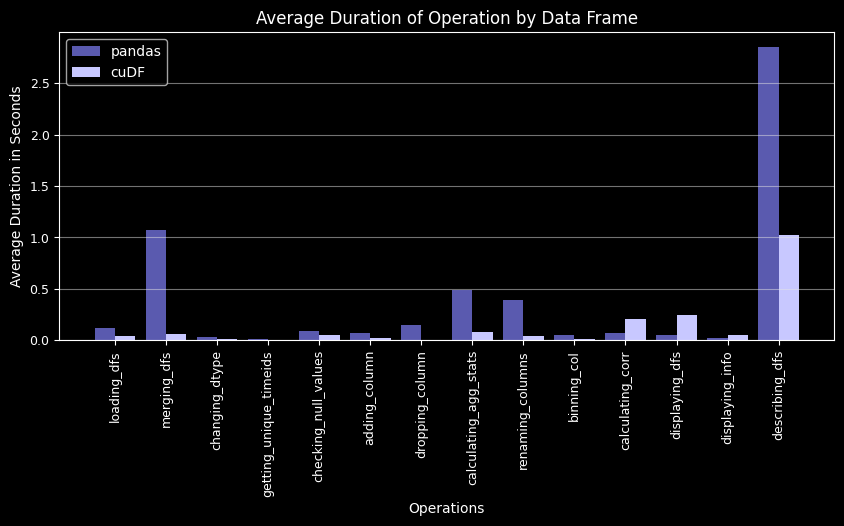

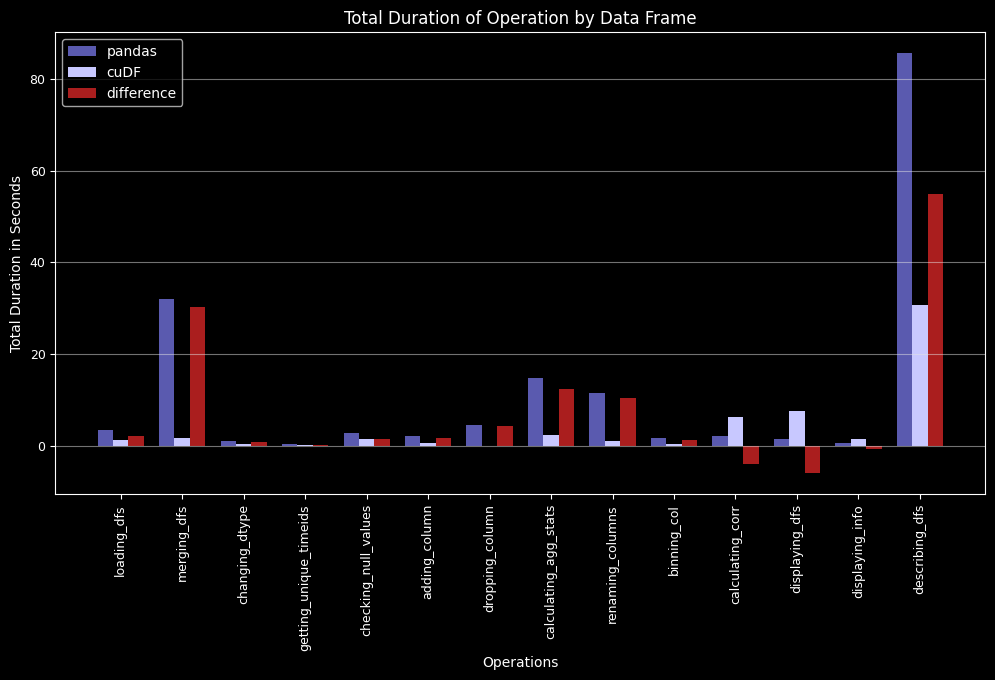

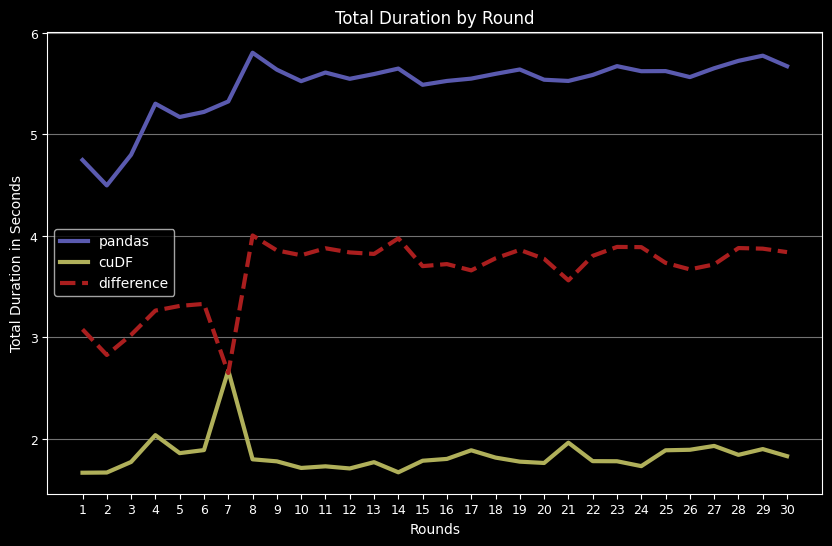

In [ ]:
calc_exec_times()